In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})
plt.rcParams['axes.unicode_minus'] = False

# 生产线数据处理

In [ ]:
df_1 = pd.read_csv("data/analysis/M301.csv")

遍历每一条生产线提取以天为颗粒度的数据

## 数据预处理

In [13]:
fault_columns = ['物料推送装置故障1001', '物料检测装置故障2001', '填装装置检测故障4001', '填装装置定位故障4002','填装装置填装故障4003', 
                 '加盖装置定位故障5001', '加盖装置加盖故障5002','拧盖装置定位故障6001', '拧盖装置拧盖故障6002']

In [14]:
def update_machine_info(data_, fault_columns):
    data_[fault_columns] = data_[fault_columns].replace({1001: 1, 2001: 1, 4001: 1, 4002: 1, 4003: 1, 5001: 1, 5002: 1, 6001: 1, 6002: 1})
    data_['机器状态'] = 0
    data_['机器状态'] = data_[fault_columns].apply(lambda x: x.idxmax() if 1 in x.to_numpy() else '正常', axis=1)
    data_['机器状态'] = data_['机器状态'].map({
    '正常': 0,
    '物料推送装置故障1001': 1,
    '物料检测装置故障2001': 2,
    '填装装置检测故障4001': 3,
    '填装装置定位故障4002': 4,
    '填装装置填装故障4003': 5,
    '加盖装置定位故障5001': 6,
    '加盖装置加盖故障5002': 7,
    '拧盖装置定位故障6001': 8,
    '拧盖装置拧盖故障6002': 9,
})
    
    data_ = data_.drop(fault_columns,axis=1)
    return data_

## 提取故障记录 计算特征值

In [15]:
# 以天为时间颗粒度统计产量，合格率
def day_data(data_):
    day_data = pd.DataFrame(columns=['生产线编号','日期','产量','不合格数'])
    for group, data in data_.groupby(['生产线编号','日期']):
        new_row = pd.DataFrame({'生产线编号': [group[0]],'日期':[group[1]],
                                '产量': [data['合格数'].iloc[-1]], '不合格数': [data['不合格数'].iloc[-1]]})
        day_data = pd.concat([day_data, new_row], ignore_index=True)

    day_data['合格率(%)'] = day_data['产量']/(day_data['产量']+day_data['不合格数'])*100
    day_data['合格率(%)'] = np.round(day_data['合格率(%)'].astype(float),2)
    day_data = day_data.drop(columns=['不合格数']) 
    return day_data

In [16]:
# 处理操作人员数据
def operator_data(df, operator_file_path):  
    day_data_df = day_data(df)  
    operators_df = pd.read_excel(operator_file_path)  
    merge_keys = ['生产线编号']  
    if '生产编号' in operators_df.columns:  
        merge_keys.append('生产编号')  
      
    merged_data = pd.merge(day_data_df, operators_df, on=merge_keys, how='left')  
    return merged_data  

In [ ]:
operator_file_path = 'data/analysis/操作人员信息表.xlsx'  
day_data_df = operator_data(df_1, operator_file_path)
day_data_df

,生产线编号,日期,产量,合格率(%),操作人员编号,工龄
0,M301,1,1416,100.00,A001,1
1,M301,2,1440,100.00,A001,1
2,M301,3,1420,100.00,A001,1
3,M301,4,1444,100.00,A001,1
4,M301,5,1356,99.34,A001,1
...,...,...,...,...,...,...
255,M301,358,1436,100.00,A001,1
256,M301,359,1443,100.00,A001,1
257,M301,360,1404,100.00,A001,1
258,M301,361,1447,100.00,A001,1


In [18]:
# 找到连续序列，记录故障起始值和持续时间
def continuous_time(group,arr,fault_records):
    start = None
    count = 0
    
    for i in range(len(arr)):
        if start is None:
            start = arr[i]
            count = 1
        elif arr[i] == arr[i-1] + 1:
            count += 1
        else:
            fault_records.append(group+(start, count))
            start = arr[i]
            count = 1
    
    if start is not None:
        fault_records.append(group+(start, count))
    
    return fault_records

In [19]:
#取出故障记录
def get_fault_records(data):
    columns = ['日期','时间','机器状态']
    
    new_data = update_machine_info(data, fault_columns)
    new_data = new_data[columns][new_data['机器状态'] != 0].sort_values(['机器状态', '日期', '时间'], ascending=[True, True, True])

    fault_records = []
    for group, data in new_data.groupby(['机器状态','日期']):
        continuous_time(group,data['时间'].to_numpy(),fault_records)
    fault_records = pd.DataFrame(fault_records,columns=['机器状态', '日期', '开始时间', '持续时间'])

    return fault_records

In [ ]:
fault_records = get_fault_records(df_1)
fault_records

,机器状态,日期,开始时间,持续时间
0,1,3,16838,181
1,1,5,2047,189
2,1,18,19023,183
3,1,32,8841,198
4,1,38,18233,185
...,...,...,...,...
298,9,324,3459,200
299,9,327,25553,195
300,9,332,8295,169
301,9,337,13458,187


In [ ]:
#统计每日单个故障持续时间
def daily_fault_durations(fault_records):  
    daily_durations = fault_records.groupby(['日期', '机器状态'])['持续时间'].sum().reset_index()  
    daily_durations.columns = ['日期', '机器状态', '单个故障持续时间']  
    return daily_durations  
    
daily_fault_duration = daily_fault_durations(fault_records)
daily_fault_duration

,日期,机器状态,单个故障持续时间
0,1,2,174
1,1,4,169
2,3,1,181
3,3,9,350
4,5,1,189
...,...,...,...
278,353,3,179
279,354,8,196
280,358,7,191
281,359,1,161


In [22]:
#故障及持续时间图
def daily_fault_summary(fault_records):   
    fault_counts = fault_records.pivot_table(index='日期', columns='机器状态', aggfunc='size', fill_value=0)  
    fault_counts.columns = ['故障' + str(col) for col in fault_counts.columns]  

    grouped_durations = fault_records.groupby(['日期', '机器状态'])['持续时间'].sum().reset_index()  
      
    def machine_state_to_column_name(state):  
        return f"故障{state}持续时间"  
      
    column_mapping = {state: machine_state_to_column_name(state) for state in grouped_durations['机器状态'].unique()}  
      
    fault_durations = grouped_durations.pivot(index='日期', columns='机器状态', values='持续时间').rename(columns=column_mapping).fillna(0)  

    fault_summary = pd.concat([fault_counts, fault_durations], axis=1)  
      
    fault_summary = fault_summary.reset_index()  
    
    return fault_summary  
  
daily_fault_summary_df = daily_fault_summary(fault_records)  
daily_fault_summary_df

,日期,故障1,故障2,故障3,故障4,故障5,故障6,故障7,故障8,故障9,故障1持续时间,故障2持续时间,故障3持续时间,故障4持续时间,故障5持续时间,故障6持续时间,故障7持续时间,故障8持续时间,故障9持续时间
0,1,0,1,0,1,0,0,0,0,0,0.0,174.0,0.0,169.0,0.0,0.0,0.0,0.0,0.0
1,3,1,0,0,0,0,0,0,0,2,181.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.0
2,5,1,0,1,0,0,0,0,0,1,189.0,0.0,186.0,0.0,0.0,0.0,0.0,0.0,176.0
3,15,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,0.0,0.0
4,17,0,1,0,0,0,0,1,0,0,0.0,198.0,0.0,0.0,0.0,0.0,161.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,353,0,0,1,0,0,0,0,0,0,0.0,0.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0
170,354,0,0,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.0,0.0
171,358,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,191.0,0.0,0.0
172,359,1,0,0,0,0,0,0,0,0,161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 合成并导出文件

In [ ]:
def merge_dataframes(day_data_df, daily_fault_summary_df):  
    merged_df = pd.merge(day_data_df, daily_fault_summary_df, on='日期', how='left')  

    merged_df.fillna(0, inplace=True) 
    
    return merged_df  
  
daily_fault_summary_result = daily_fault_summary(fault_records) 

merge_df = merge_dataframes(day_data_df, daily_fault_summary_result)
merge_df

,生产线编号,日期,产量,合格率(%),操作人员编号,工龄,故障1,故障2,故障3,故障4,...,故障9,故障1持续时间,故障2持续时间,故障3持续时间,故障4持续时间,故障5持续时间,故障6持续时间,故障7持续时间,故障8持续时间,故障9持续时间
0,M301,1,1416,100.00,A001,1,0.0,1.0,0.0,1.0,...,0.0,0.0,174.0,0.0,169.0,0.0,0.0,0.0,0.0,0.0
1,M301,2,1440,100.00,A001,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M301,3,1420,100.00,A001,1,1.0,0.0,0.0,0.0,...,2.0,181.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.0
3,M301,4,1444,100.00,A001,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M301,5,1356,99.34,A001,1,1.0,0.0,1.0,0.0,...,1.0,189.0,0.0,186.0,0.0,0.0,0.0,0.0,0.0,176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,M301,358,1436,100.00,A001,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,191.0,0.0,0.0
256,M301,359,1443,100.00,A001,1,1.0,0.0,0.0,0.0,...,0.0,161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,M301,360,1404,100.00,A001,1,1.0,0.0,0.0,0.0,...,0.0,188.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
258,M301,361,1447,100.00,A001,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 导出为csv文件
merge_df.to_csv('data/analysis/combined_data_1.csv', index=False)

## 故障与次品时间散点图

In [25]:
def get_unqualified_records(df):
    unqualified_records = df[df['不合格数'] == 1]  
    unqualified_records = unqualified_records.iloc[ : ,0:3]
    return unqualified_records
unqualified_records = get_unqualified_records(df)
get_unqualified_records(df)

,日期,时间,生产线编号
142401,5,26691,M301
142402,5,26692,M301
142403,5,26693,M301
142404,5,26694,M301
142405,5,26695,M301
...,...,...,...
7301436,353,4376,M301
7301437,353,4377,M301
7301438,353,4378,M301
7301439,353,4379,M301


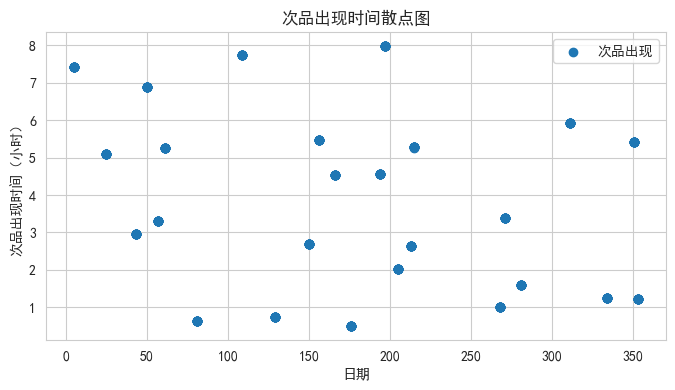

In [26]:
def unqualified_scatter(df):  
    unqualified_records['时间'] = pd.to_timedelta(unqualified_records['时间'], unit='s')  
    unqualified_records['小时'] = unqualified_records['时间'].dt.total_seconds() / 3600  
 
    plt.figure(figsize=(8, 4))  
    plt.scatter(unqualified_records['日期'],  unqualified_records['小时'],label='次品出现')  

    plt.xlabel('日期')  
    plt.ylabel('次品出现时间（小时）')  
    plt.title('次品出现时间散点图')  
    plt.legend()
unqualified_scatter(unqualified_records)

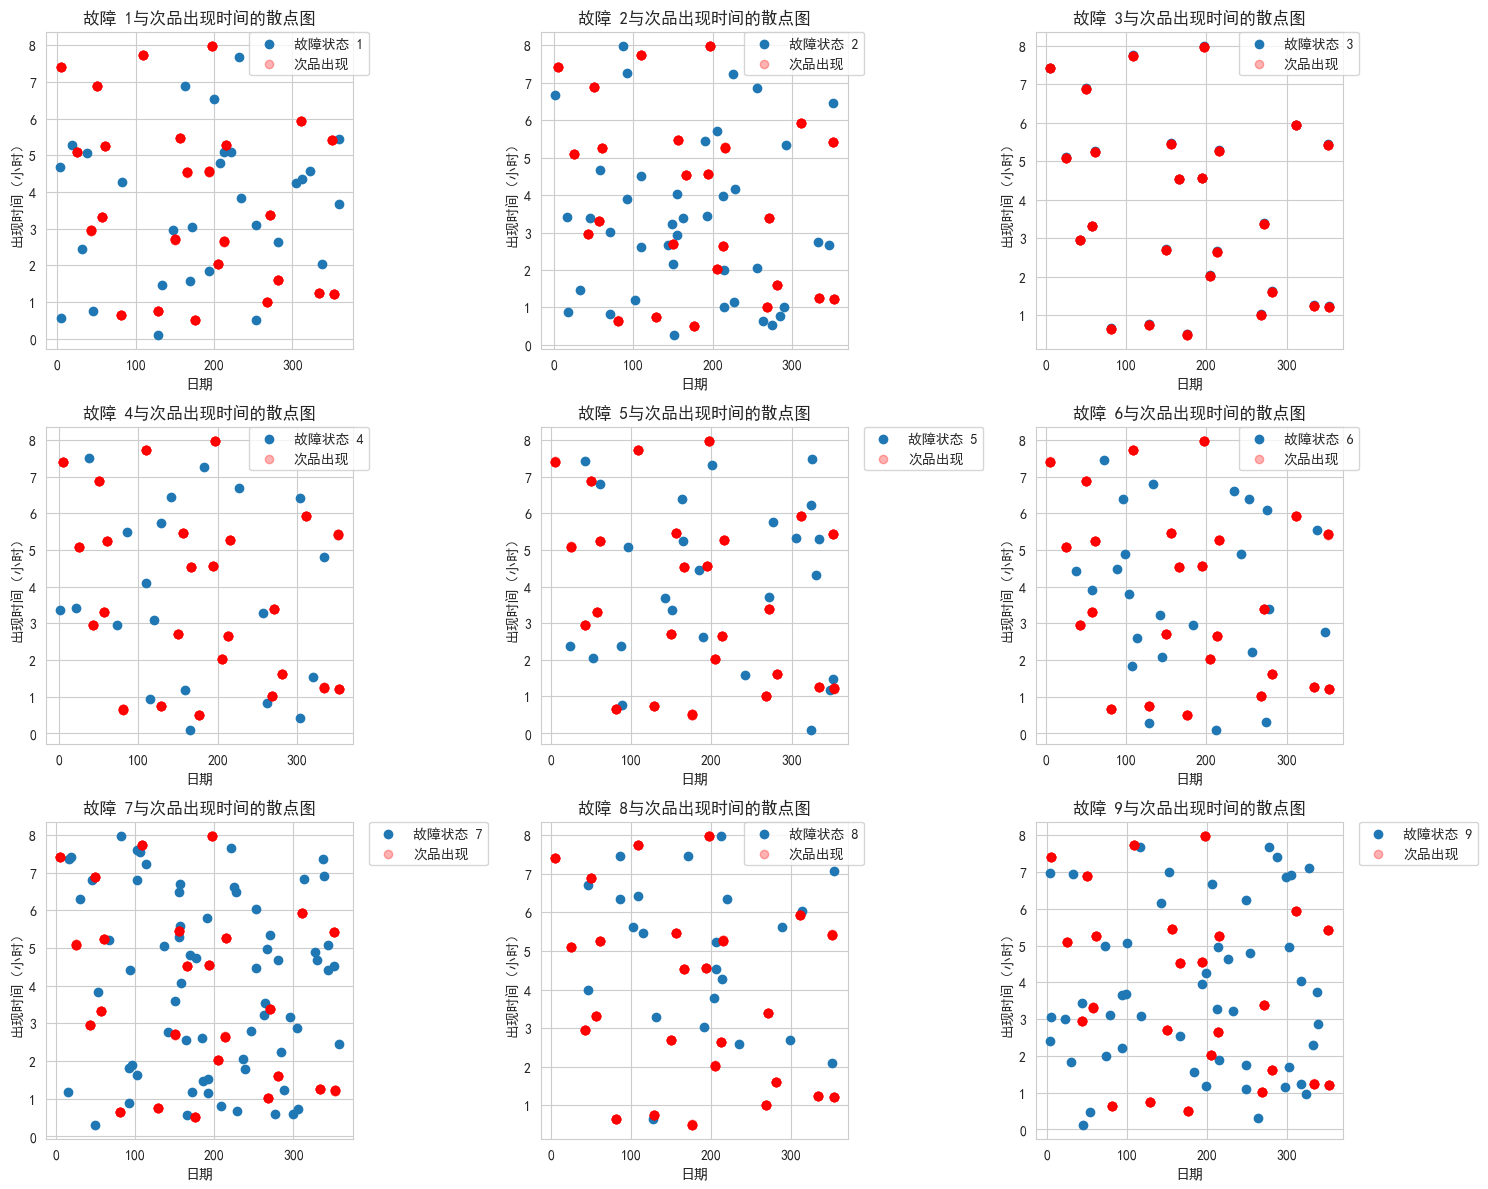

In [29]:
def fault_and_unqualified_scatter(fault_records, unqualified_records):  
    fault_records['开始时间'] = pd.to_timedelta(fault_records['开始时间'], unit='s')  
    fault_records['小时'] = fault_records['开始时间'].dt.total_seconds() / 3600  
      
    unqualified_records['时间'] = pd.to_timedelta(unqualified_records['时间'], unit='s')  
    unqualified_records['小时'] = unqualified_records['时间'].dt.total_seconds() / 3600  
    unique_states = fault_records['机器状态'].unique()  
      
    num_subplots = len(unique_states)  
    num_cols = 3  
    num_rows = (num_subplots + num_cols - 1) // num_cols  
      
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,12))  

    for i, state in enumerate(unique_states):  
        row_idx = i // num_cols  
        col_idx = i % num_cols  
        ax = axs[row_idx, col_idx]  
          
        subset = fault_records[fault_records['机器状态'] == state]  
          
        ax.scatter(subset['日期'], subset['小时'], label=f'故障状态 {state}')  
          
        ax.scatter(unqualified_records['日期'], unqualified_records['小时'], color='red', label='次品出现', alpha=0.3)  
          
        # 设置x轴和y轴标签  
        ax.set_xlabel('日期')  
        ax.set_ylabel('出现时间（小时）')  
           
        ax.set_title(f'故障 {state}与次品出现时间的散点图')  
        ax.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)  
       
    plt.tight_layout()  
    plt.show()  
  
fault_and_unqualified_scatter(fault_records, unqualified_records)

# 绘制相关系数热力图

In [ ]:
df = pd.read_csv("data/analysis/combined_data.csv")

           产量  合格率(%)    工龄   故障1   故障2   故障3   故障4   故障5   故障6   故障7  ...  \
产量       1.00    0.05 -0.18 -0.07 -0.36 -0.05 -0.08 -0.06 -0.00 -0.12  ...   
合格率(%)   0.05    1.00  0.03 -0.02  0.02 -1.00 -0.01 -0.01  0.00  0.03  ...   
工龄      -0.18    0.03  1.00  0.01 -0.01 -0.03  0.06 -0.00 -0.03 -0.03  ...   
故障1     -0.07   -0.02  0.01  1.00 -0.03  0.02 -0.02 -0.03  0.01  0.02  ...   
故障2     -0.36    0.02 -0.01 -0.03  1.00 -0.02  0.01 -0.00 -0.02  0.00  ...   
故障3     -0.05   -1.00 -0.03  0.02 -0.02  1.00  0.00  0.01 -0.00 -0.03  ...   
故障4     -0.08   -0.01  0.06 -0.02  0.01  0.00  1.00 -0.01  0.04 -0.04  ...   
故障5     -0.06   -0.01 -0.00 -0.03 -0.00  0.01 -0.01  1.00  0.00 -0.01  ...   
故障6     -0.00    0.00 -0.03  0.01 -0.02 -0.00  0.04  0.00  1.00 -0.01  ...   
故障7     -0.12    0.03 -0.03  0.02  0.00 -0.03 -0.04 -0.01 -0.01  1.00  ...   
故障8     -0.07    0.03  0.10 -0.05  0.01 -0.03  0.01  0.01 -0.00 -0.00  ...   
故障9     -0.02    0.00 -0.07  0.01 -0.01 -0.01 -0.01 -0.03 -0.01 

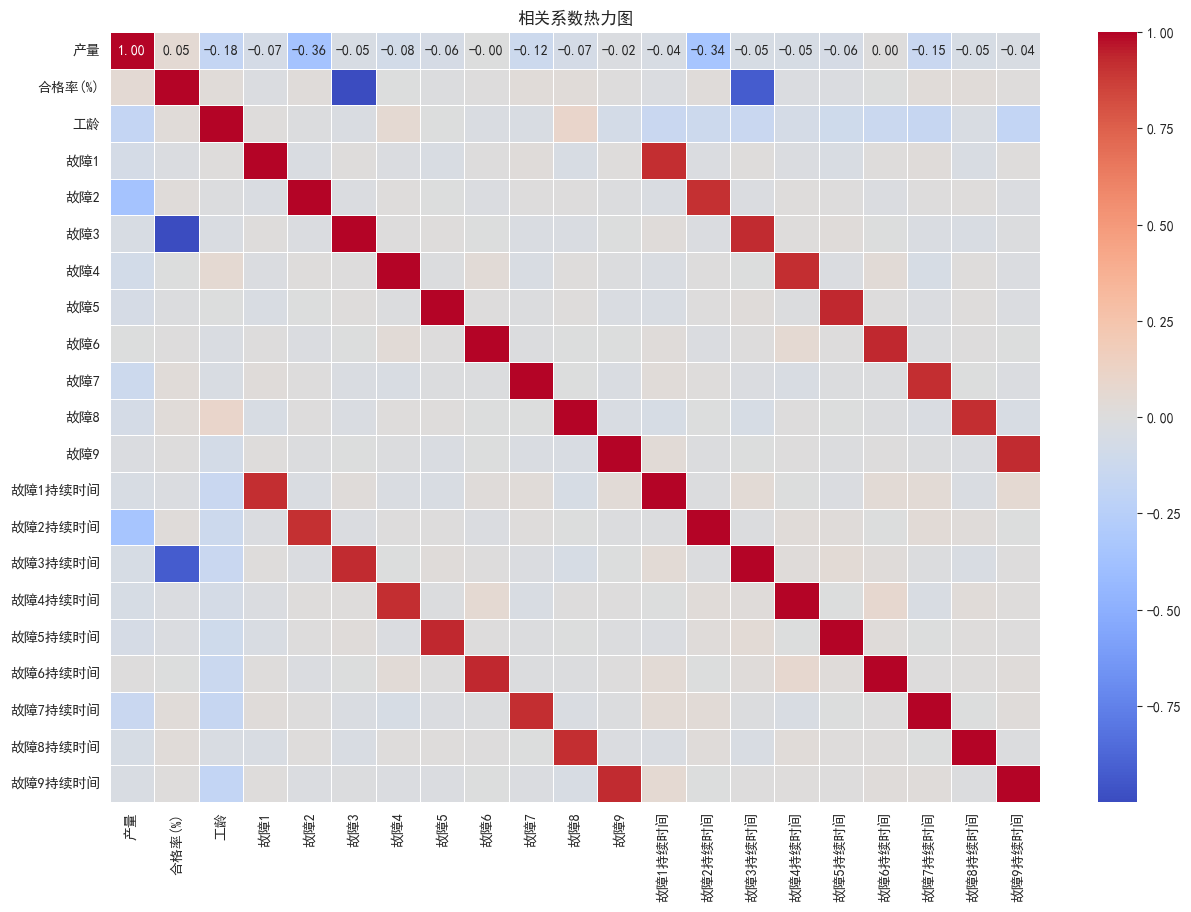

In [4]:
#绘制相关系数热力图
selected_columns = df.iloc[:, 2:4].columns.tolist() + df.iloc[:, 5:].columns.tolist()  

corr_matrix = df[selected_columns].corr()  
corr_matrix_rounded = corr_matrix.round(2)  
print(corr_matrix_rounded) 

plt.figure(figsize=(15, 10))  
sns.heatmap(corr_matrix,  
            xticklabels=corr_matrix.columns,  
            yticklabels=corr_matrix.columns,   
            annot=True, 
            cmap='coolwarm',  
            linewidths=0.5,
            fmt='.2f') 
  
plt.title('相关系数热力图')  
plt.show()

# 生产线与产量的关系分析

In [5]:
#绘制各条生产线箱线图
def boxplot_for_line(data, line_number, position, xlabel):  
    plt.subplot(nrows, ncols, position)
    plt.boxplot(data, vert=False, patch_artist=True, widths=0.6)  
    plt.xlabel(xlabel)  
    plt.title(f'生产线 {line_number}{xlabel} 箱线图')  
    plt.grid(axis='x', alpha=0.75) 

In [6]:
#绘制各条生产线折线图
def line_chart_for_line(x, y, line_number, position, ax, ylabel):
    ax.plot(x, y, linewidth=0.3)
    ax.set_xlabel('日期')
    ax.set_ylabel(ylabel)
    ax.set_title(f'生产线 {line_number}{ylabel} 折线图')
    ax.grid(axis='y', alpha=0.75)

## 各条生产线的平均产量及产量分布

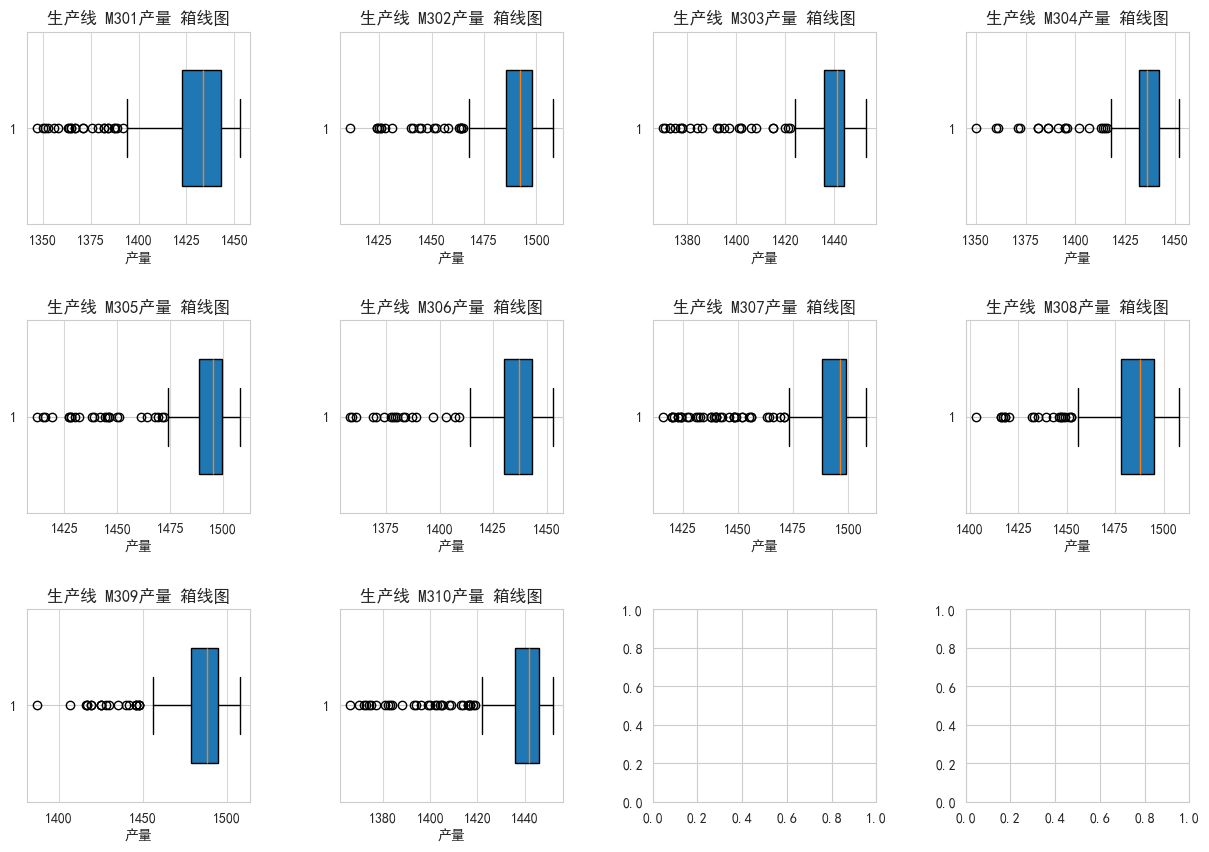

In [7]:
#绘制各条生产线产量箱线图
unique_lines = df['生产线编号'].unique()  
ncols = 4  
nrows = (len(unique_lines) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))  
  
for i, line_number in enumerate(unique_lines):  
  
    line_data = df[df['生产线编号'] == line_number]['产量']  
    
    boxplot_for_line(line_data, line_number, i + 1, xlabel = '产量')  
  
plt.subplots_adjust(hspace=0.5, wspace=0.4) 
  
plt.show()

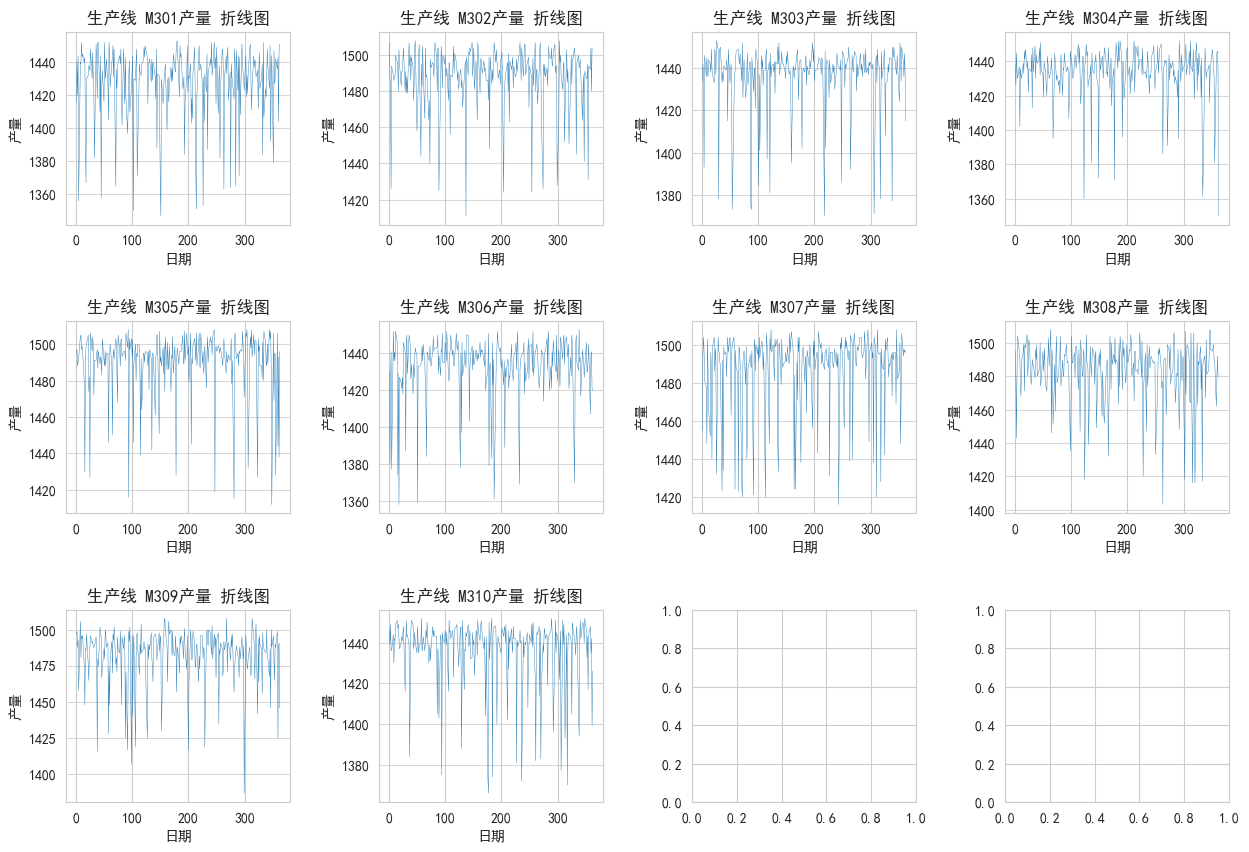

In [8]:
#绘制各条生产线产量折线图
unique_lines = df['生产线编号'].unique()
ncols = 4
nrows = (len(unique_lines) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for i, line_number in enumerate(unique_lines):
    line_data = df[df['生产线编号'] == line_number]
    dates = line_data['日期']
    production = line_data['产量']

    line_chart_for_line(dates, production, line_number, i + 1, axes[i // ncols, i % ncols], ylabel='产量')

plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show()

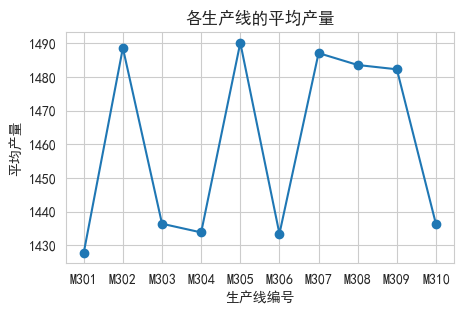

62.36538461538453


In [11]:
#绘制各条生产线平均产量图
average_output_per_line = df.groupby('生产线编号')['产量'].mean()  
  
line_names_output = average_output_per_line.index.tolist()  
average_outputs = average_output_per_line.values.tolist()  
  
plt.figure(figsize=(5, 3))  
plt.plot(line_names_output, average_outputs, marker='o')  
  
plt.xlabel('生产线编号')  
plt.ylabel('平均产量')  
plt.title('各生产线的平均产量')  
plt.show()
print(average_output_per_line.max()-average_output_per_line.min())

## 各条生产线的故障情况

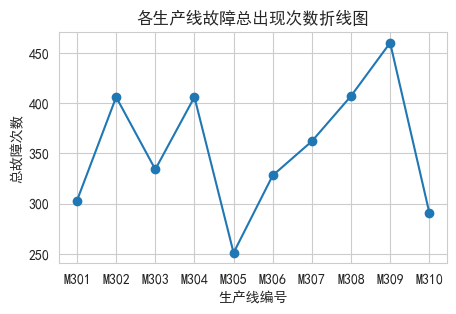

In [13]:
#绘制各条生产线故障总出现次数图
df['总故障次数'] = df[['故障1', '故障2', '故障3', '故障4', '故障5', '故障6', '故障7', '故障8', '故障9']].sum(axis=1)  

production_line_faults = df.groupby('生产线编号')['总故障次数'].sum().reset_index()  
 
plt.figure(figsize=(5, 3))   
plt.plot(production_line_faults['生产线编号'], production_line_faults['总故障次数'], marker='o')  
plt.title('各生产线故障总出现次数折线图')  
plt.xlabel('生产线编号')  
plt.ylabel('总故障次数')  
plt.show()

Text(0, 0.5, '总故障时间')

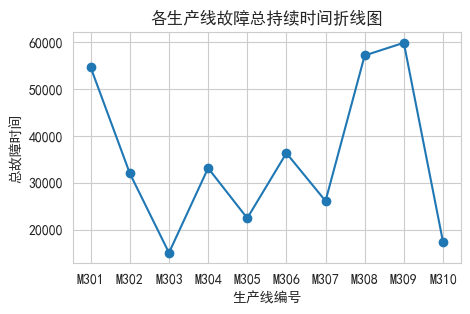

In [56]:
#绘制各条生产线故障总持续时间折线图
df['故障总持续时间'] = df[[f'故障{i+1}持续时间' for i in range(9)]].sum(axis=1)  
production_line_total_time = df.groupby('生产线编号')['故障总持续时间'].sum().reset_index()  
  
plt.figure(figsize=(5, 3))  
plt.plot(production_line_total_time['生产线编号'], production_line_total_time['故障总持续时间'], marker='o')  

plt.title('各生产线故障总持续时间折线图')  
plt.xlabel('生产线编号')  
plt.ylabel('总故障时间')  
#plt.show()

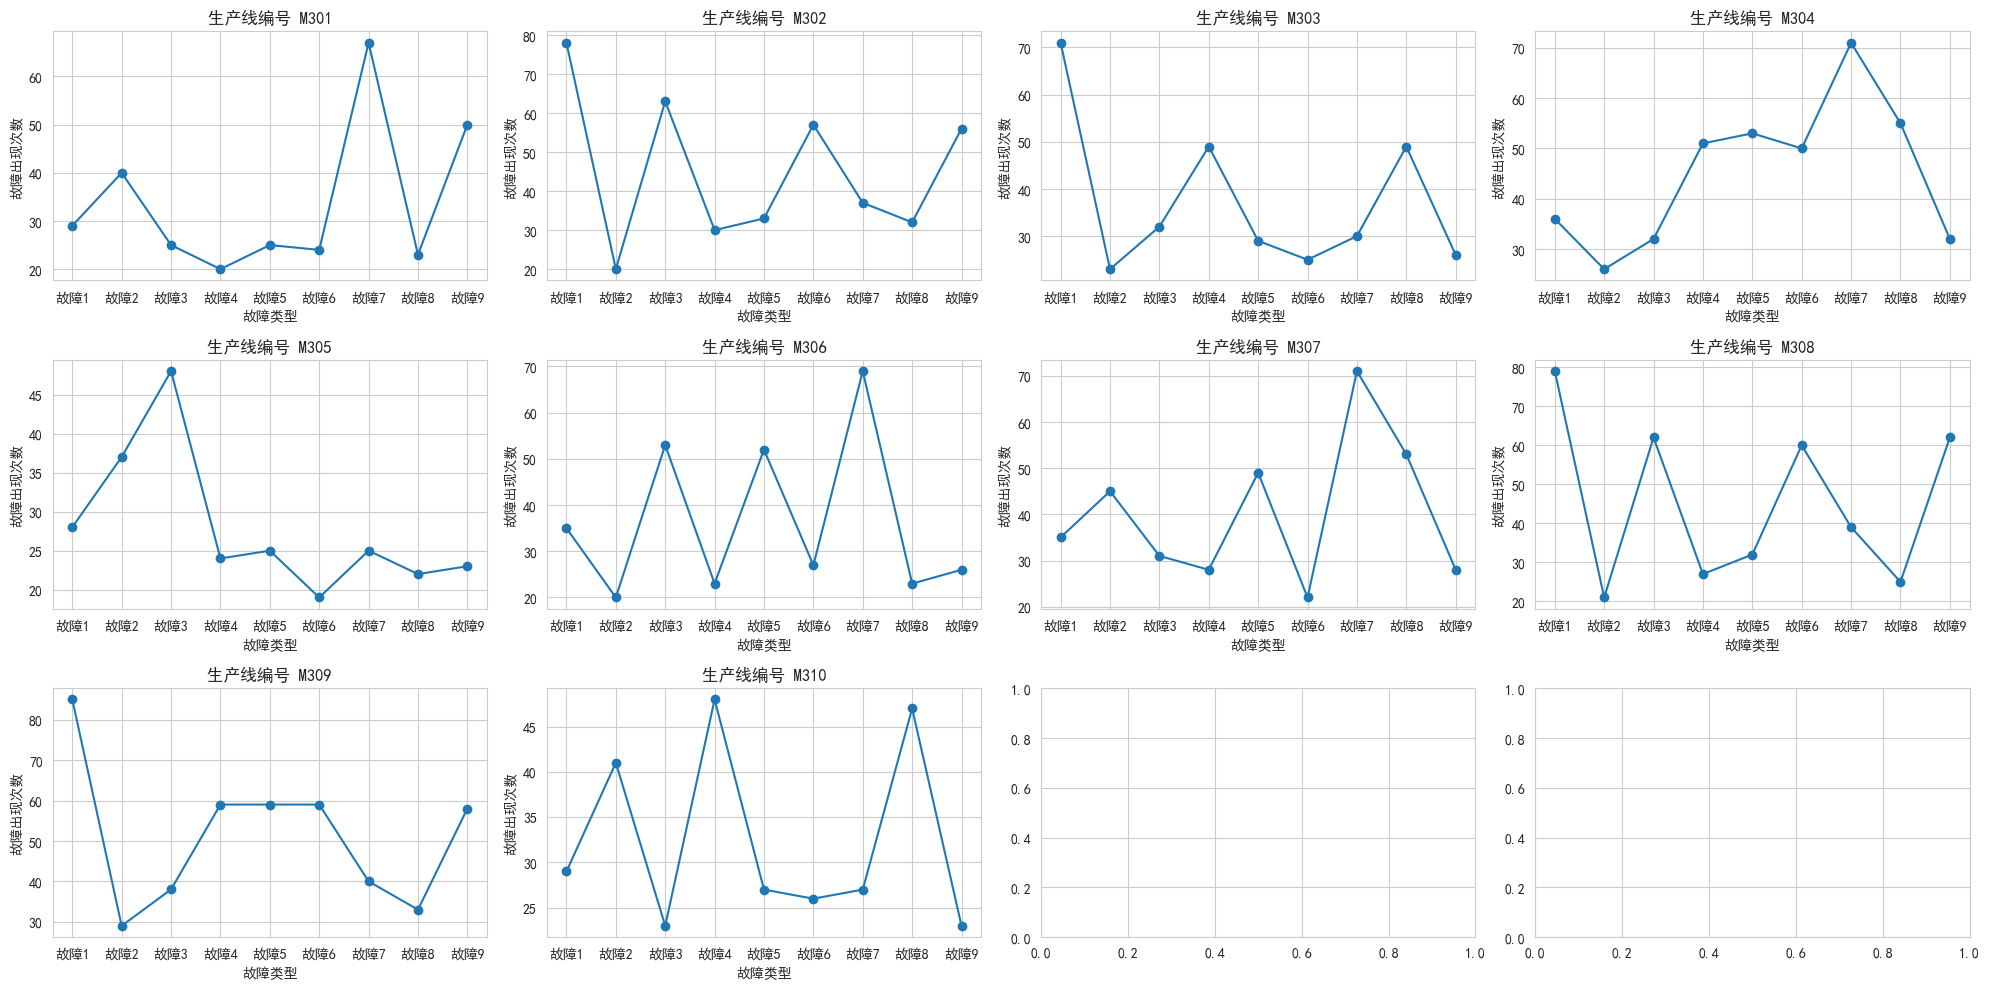

In [18]:
#绘制各条生产线各故障次数图
faults = [f'故障{i+1}' for i in range(9)] 
faults_summary = df.groupby('生产线编号')[[f'故障{i+1}' for i in range(9)]].sum().reset_index()  
num_lines = len(faults_summary['生产线编号'].unique()) 
num_cols = 4 
num_rows = (num_lines + num_cols - 1) // num_cols  
  
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))   
axs = axs.flatten()  
  
for i, (index, line_faults) in enumerate(faults_summary.groupby('生产线编号')):  
    ax = axs[i] 
    ax.plot(faults, line_faults[[f'故障{i+1}' for i in range(9)]].values[0], marker='o')  
    ax.set_title(f'生产线编号 {index}')  
    ax.set_xlabel('故障类型')  
    ax.set_ylabel('故障出现次数')  
    ax.set_xticks(range(len(faults)))  
      
plt.tight_layout()  
plt.show()

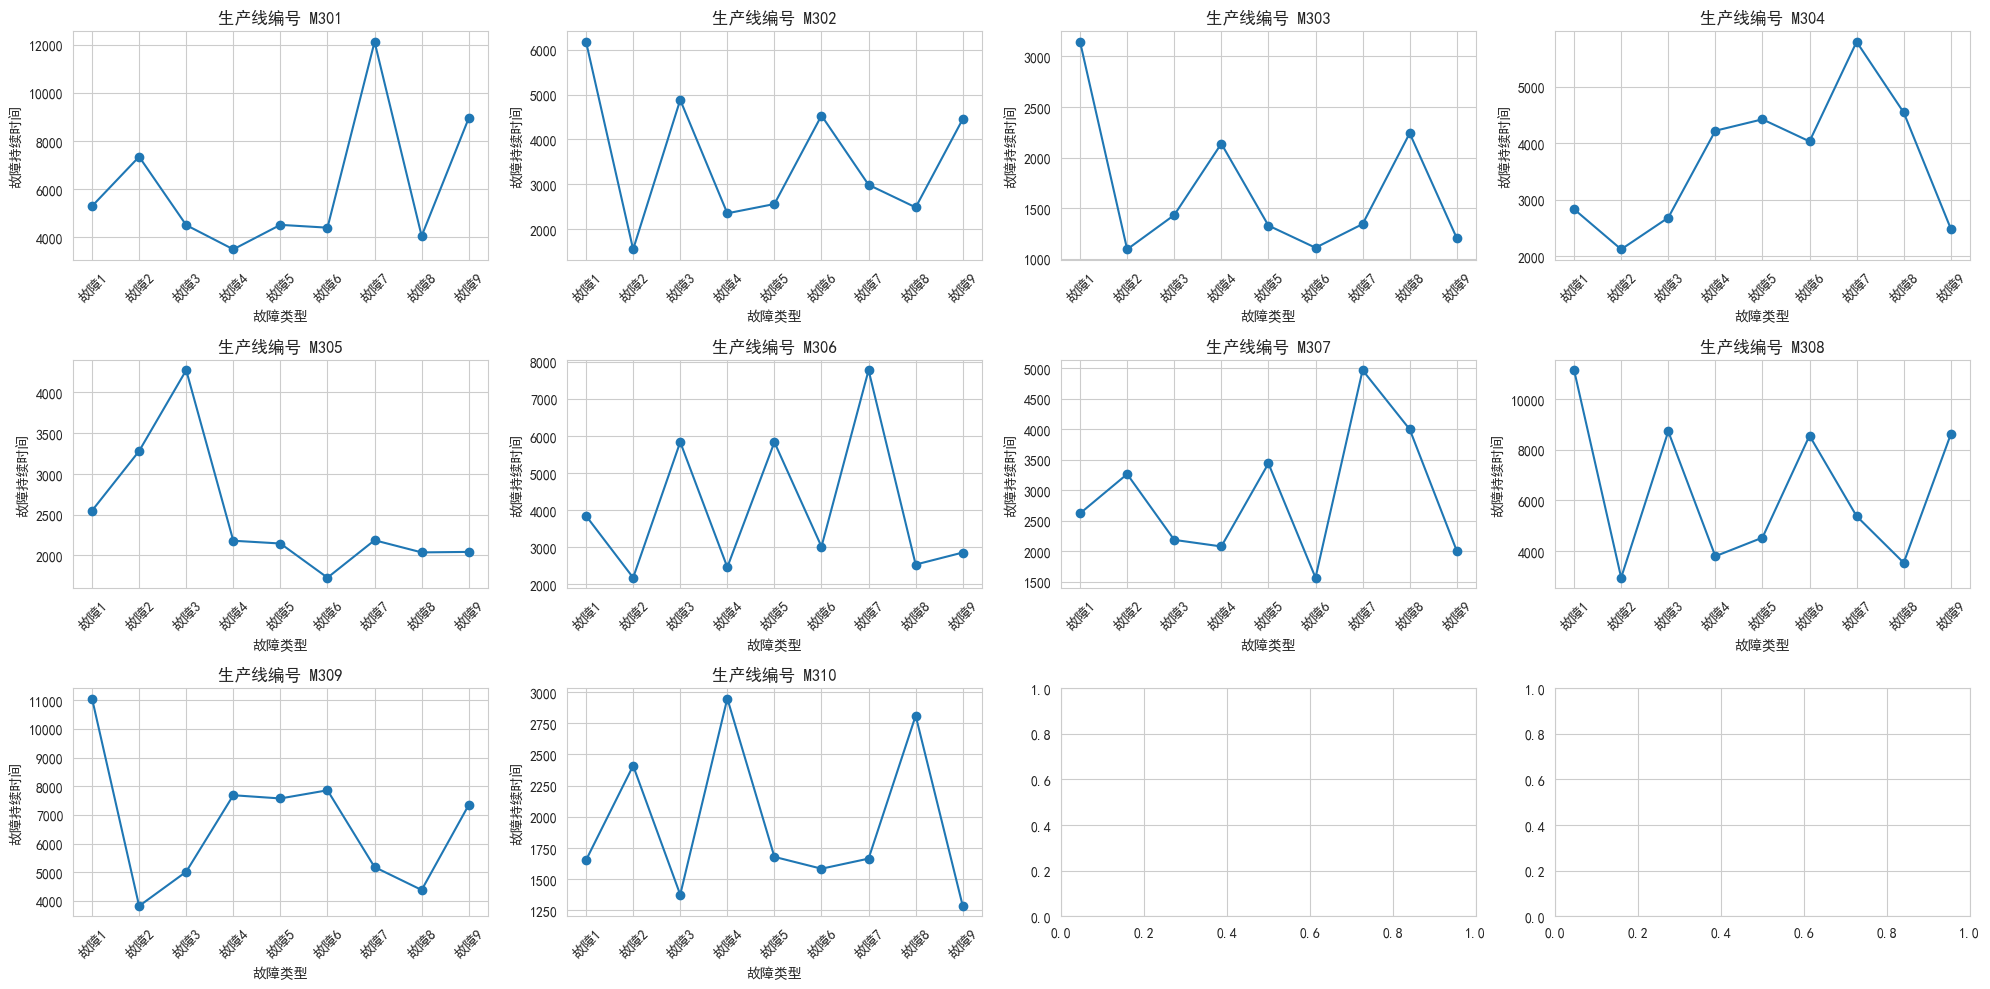

In [20]:
#绘制各条生产线各故障持续时间折线图
faults_duration = [f'故障{i+1}持续时间' for i in range(9)]  
   
faults_duration_summary = df.groupby('生产线编号')[faults_duration].sum().reset_index()  
  
num_lines = len(faults_duration_summary['生产线编号'].unique())  
num_cols = 4  
num_rows = (num_lines + num_cols - 1) // num_cols  
  
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))  
axs = axs.flatten()  
 
for i, (index, line_faults) in enumerate(faults_duration_summary.groupby('生产线编号')):  
    ax = axs[i]  

    line_faults_duration = line_faults[faults_duration].values[0]  

    fault_labels = [label.replace('持续时间', '') for label in faults_duration]  
      
    ax.plot(fault_labels, line_faults_duration, marker='o')  
    ax.set_title(f'生产线编号 {index}')  
    ax.set_xlabel('故障类型')  
    ax.set_ylabel('故障持续时间')  
    ax.set_xticks(range(len(fault_labels)))  
    ax.set_xticklabels(fault_labels, rotation=45)  
    
plt.tight_layout()  
plt.show()

## 产量显著因素（故障2）与生产线的关系

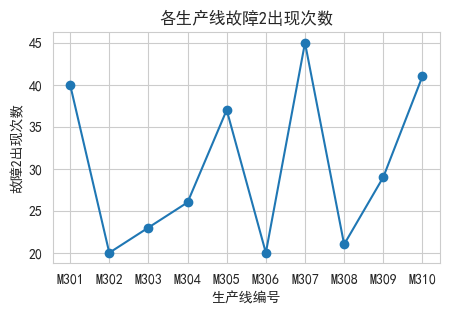

In [57]:
#绘制各条生产线故障2出现次数折线图
fault2_data = df[['生产线编号', '故障2']].copy()  
fault2_summary = fault2_data.groupby('生产线编号')['故障2'].sum().reset_index()  
  
plt.figure(figsize=(5, 3))  
plt.plot(fault2_summary['生产线编号'], fault2_summary['故障2'], marker='o')  
  
plt.xlabel('生产线编号')  
plt.ylabel('故障2出现次数')  
plt.title('各生产线故障2出现次数')  
    
plt.show()

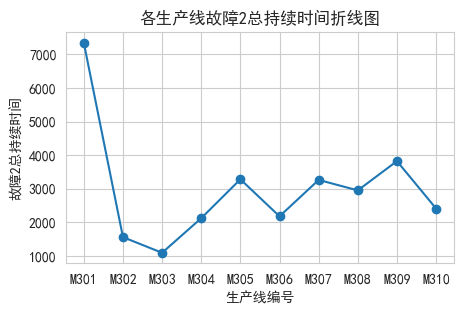

In [58]:
#绘制各条生产线故障2总持续时间折线图
fault2_duration_data = df[['生产线编号', '故障2持续时间']].copy()  
fault2_duration_summary = fault2_duration_data.groupby('生产线编号')['故障2持续时间'].sum().reset_index()  
  
plt.figure(figsize=(5, 3))  
plt.plot(fault2_duration_summary['生产线编号'], fault2_duration_summary['故障2持续时间'], marker='o')  
  
plt.xlabel('生产线编号')  
plt.ylabel('故障2总持续时间')  
plt.title('各生产线故障2总持续时间折线图')  
plt.show()

# 生产线与合格率的关系分析

## 各生产线的平均合格率及合格率分布

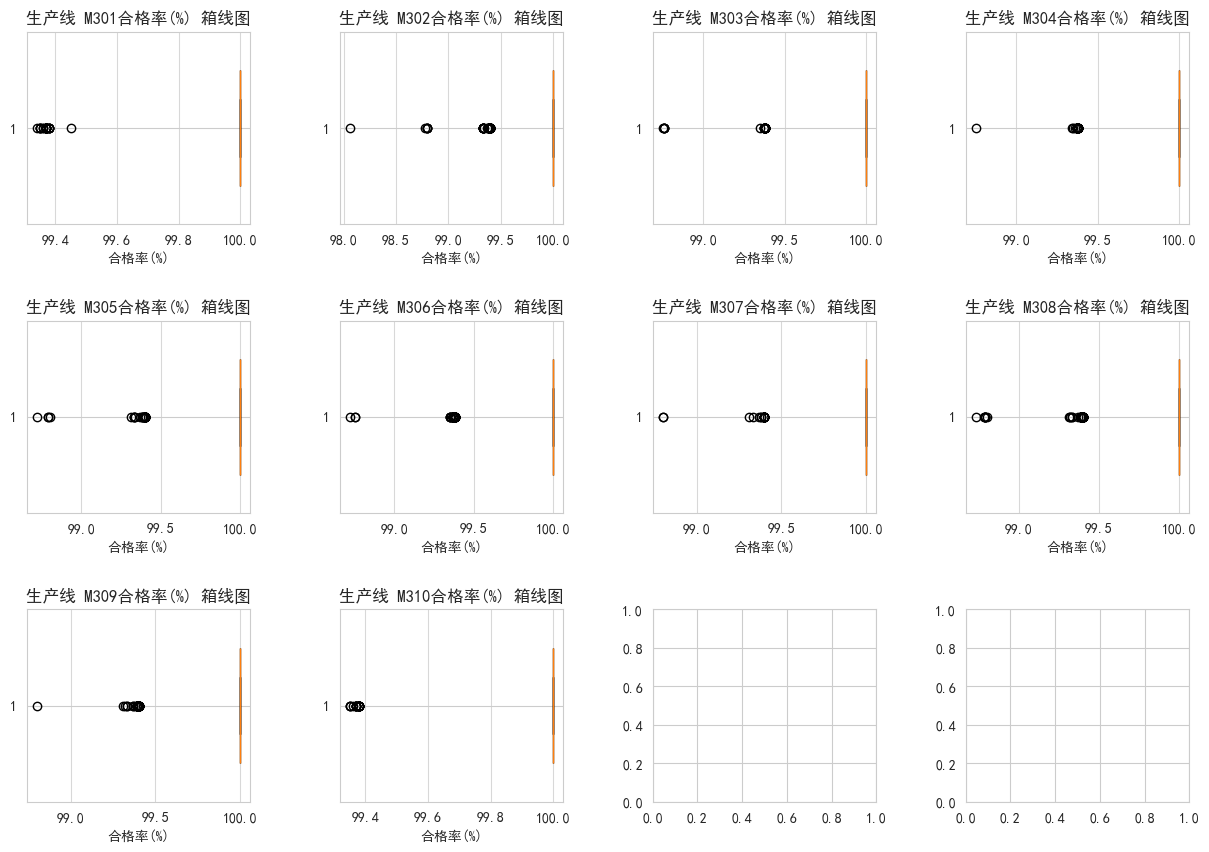

In [9]:
#绘制各条生产线合格率(%)箱线图  
unique_lines = df['生产线编号'].unique()  
ncols = 4  
nrows = (len(unique_lines) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))  
  
for i, line_number in enumerate(unique_lines):  
  
    line_data = df[df['生产线编号'] == line_number]['合格率(%)']  
    
    boxplot_for_line(line_data, line_number, i + 1, xlabel = '合格率(%)')  
  
plt.subplots_adjust(hspace=0.5, wspace=0.4) 
  
plt.show()

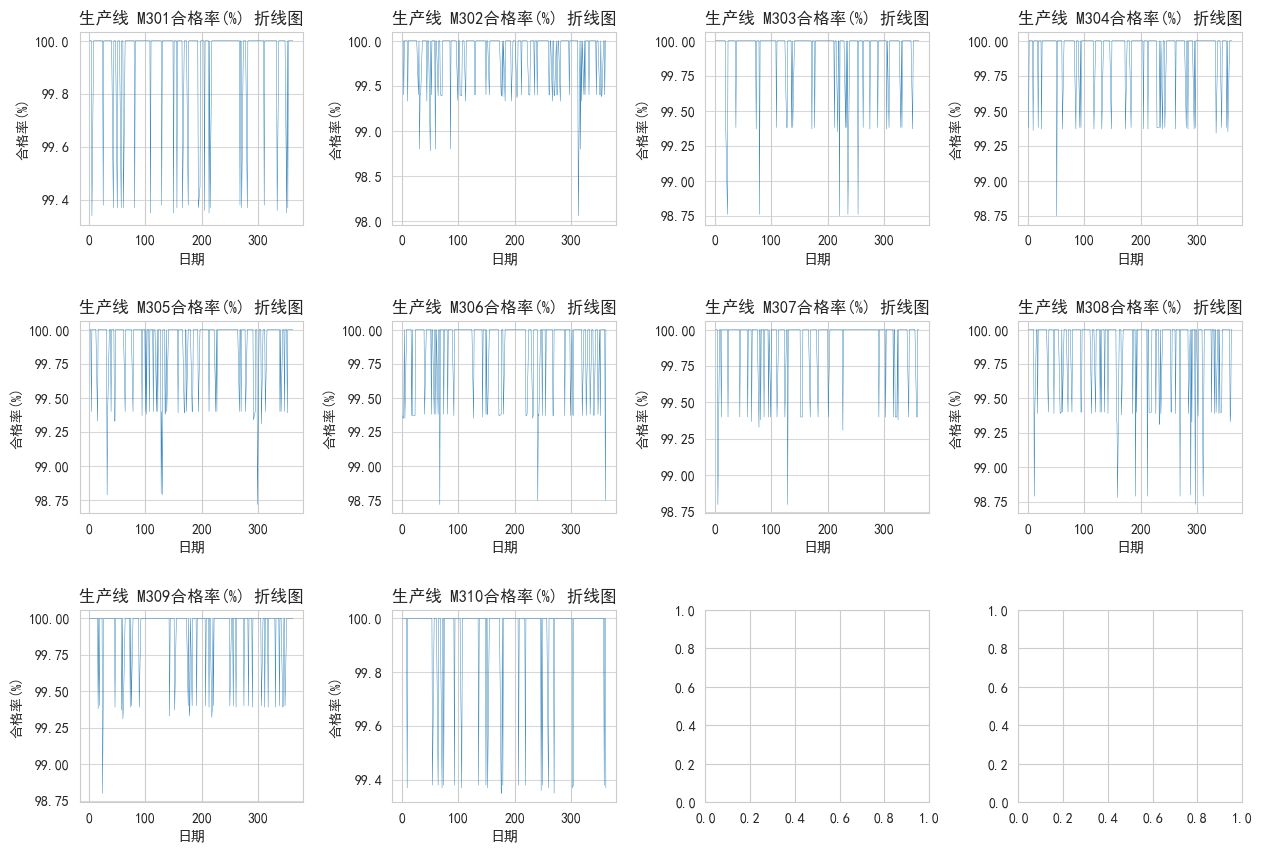

In [10]:
#绘制各条生产线产量折线图
unique_lines = df['生产线编号'].unique()
ncols = 4
nrows = (len(unique_lines) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for i, line_number in enumerate(unique_lines):
    line_data = df[df['生产线编号'] == line_number]
    dates = line_data['日期']
    production = line_data['合格率(%)']

    line_chart_for_line(dates, production, line_number, i + 1, axes[i // ncols, i % ncols], ylabel='合格率(%)')

plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show()

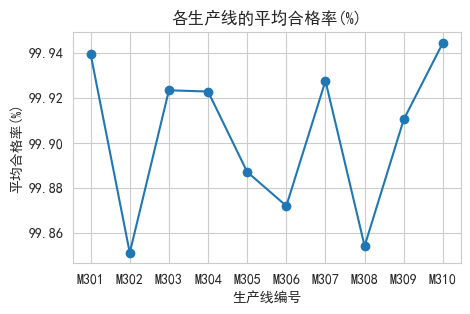

0.09330769230768965


In [12]:
#绘制各条生产线平均合格率图
average_rate_per_line = df.groupby('生产线编号')['合格率(%)'].mean()  
  
line_names_rate = average_rate_per_line.index.tolist()  
average_rate = average_rate_per_line.values.tolist()  
  
plt.figure(figsize=(5, 3))  
plt.plot(line_names_rate, average_rate, marker='o')  
  
plt.xlabel('生产线编号')  
plt.ylabel('平均合格率(%)')  
plt.title('各生产线的平均合格率(%)')  
plt.show()
print(average_rate_per_line.max()-average_rate_per_line.min())

## 合格率显著因素（故障2）与生产线的关系

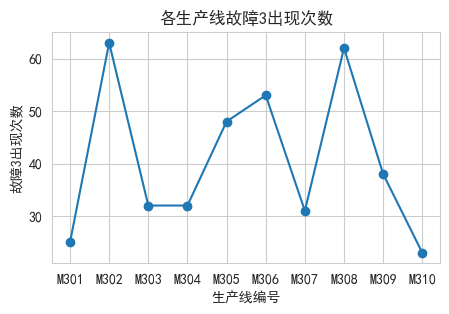

In [14]:
#绘制各条生产线故障3出现次数折线图
fault3_data = df[['生产线编号', '故障3']].copy()  
fault3_summary = fault3_data.groupby('生产线编号')['故障3'].sum().reset_index()  
  
plt.figure(figsize=(5, 3))  
plt.plot(fault3_summary['生产线编号'], fault3_summary['故障3'], marker='o')  
  
plt.xlabel('生产线编号')  
plt.ylabel('故障3出现次数')  
plt.title('各生产线故障3出现次数')  
    
plt.show()

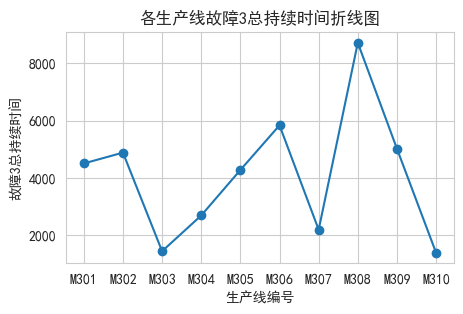

In [15]:
#绘制各条生产线故障3总持续时间折线图
fault3_duration_data = df[['生产线编号', '故障3持续时间']].copy()  
fault3_duration_summary = fault3_duration_data.groupby('生产线编号')['故障3持续时间'].sum().reset_index()  
  
plt.figure(figsize=(5, 3))  
plt.plot(fault3_duration_summary['生产线编号'], fault3_duration_summary['故障3持续时间'], marker='o')  
  
plt.xlabel('生产线编号')  
plt.ylabel('故障3总持续时间')  
plt.title('各生产线故障3总持续时间折线图')  
plt.show()

# 工龄与产量的关系分析

## 各工龄的平均产量及产量分布

In [22]:
#绘制各个工龄箱线图
def boxplot_for_age(data, work_age, position, xlabel):  
    plt.subplot(nrows, ncols, position)  
    plt.boxplot(data, vert=False, patch_artist=True, widths=0.6)  
    plt.xlabel(xlabel)  
    plt.title(f'工龄 {work_age} 箱线图')  
    plt.grid(axis='x', alpha=0.75)


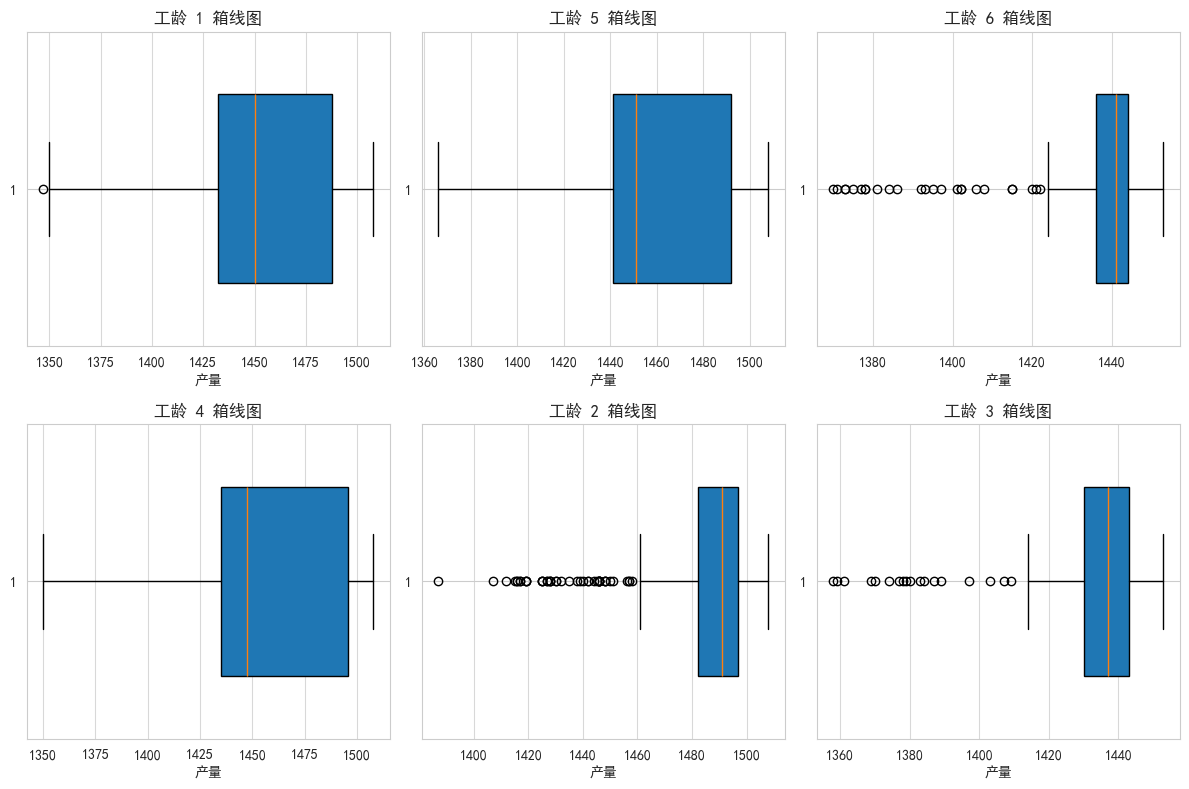

In [23]:
#绘制各个工龄产量箱线图
unique_work_ages = df['工龄'].unique() 
ncols = 3  
nrows = (len(unique_work_ages) + ncols - 1) // ncols  
  
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))  
  
for i, work_age in enumerate(unique_work_ages):  
    
    work_age_data = df[df['工龄'] == work_age]['产量']  

    boxplot_for_age(work_age_data, work_age, i + 1, xlabel = '产量')  
  
plt.tight_layout()  
plt.show()

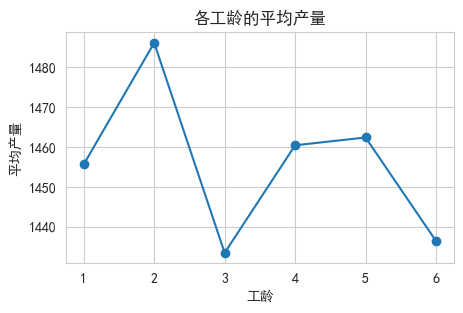

各工龄平均产量的最大差值为: 52.773076923076815


In [55]:
#绘制各工龄平均产量
average_output_per_seniority = df.groupby('工龄')['产量'].mean()  

seniority_names_output = average_output_per_seniority.index.tolist()  
average_outputs = average_output_per_seniority.values.tolist()  

plt.figure(figsize=(5, 3))  
plt.plot(seniority_names_output, average_outputs, marker='o')  

plt.xlabel('工龄')  
plt.ylabel('平均产量')  
plt.title('各工龄的平均产量')  
plt.show()  

max_diff = average_output_per_seniority.max() - average_output_per_seniority.min()  
print(f"各工龄平均产量的最大差值为: {max_diff}")

## 工龄与故障持续时间的关系分析

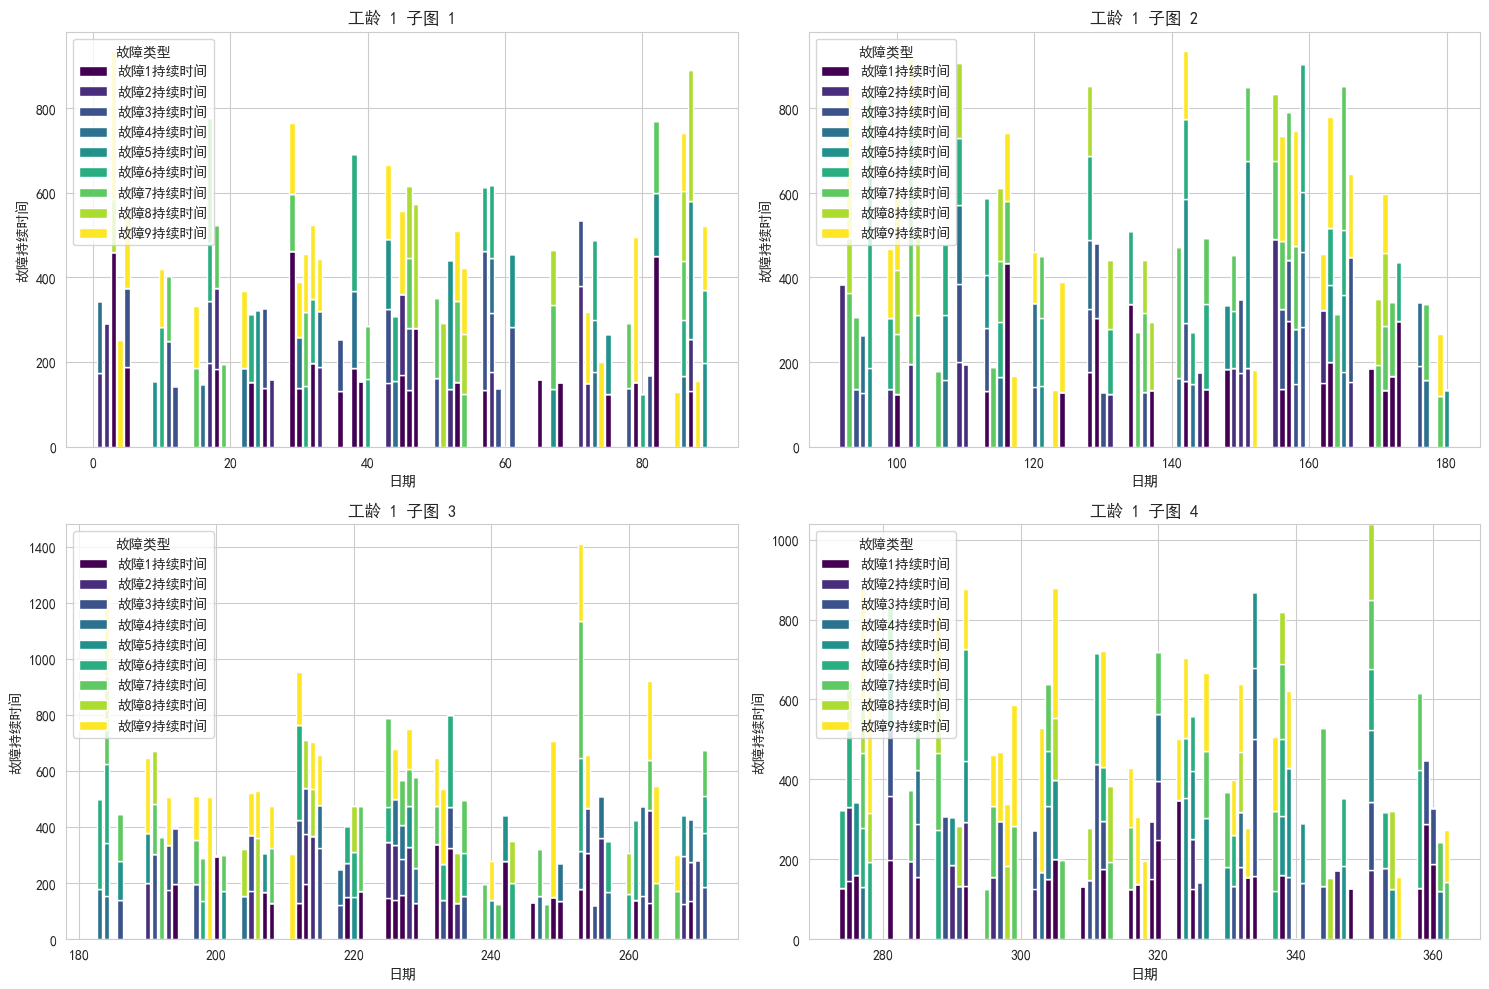

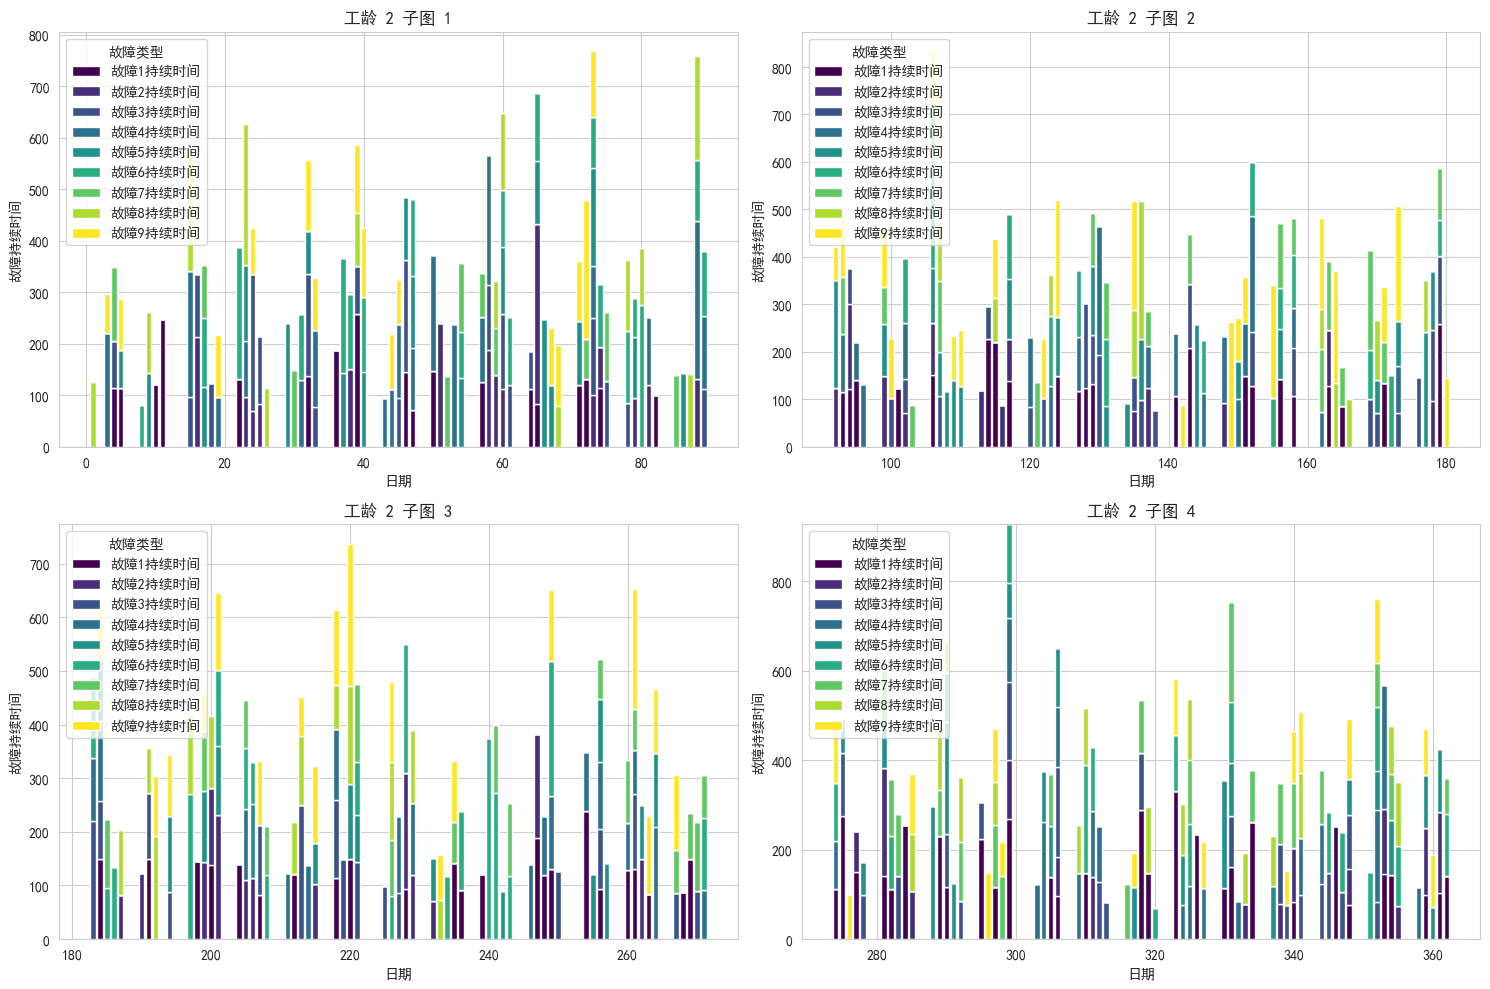

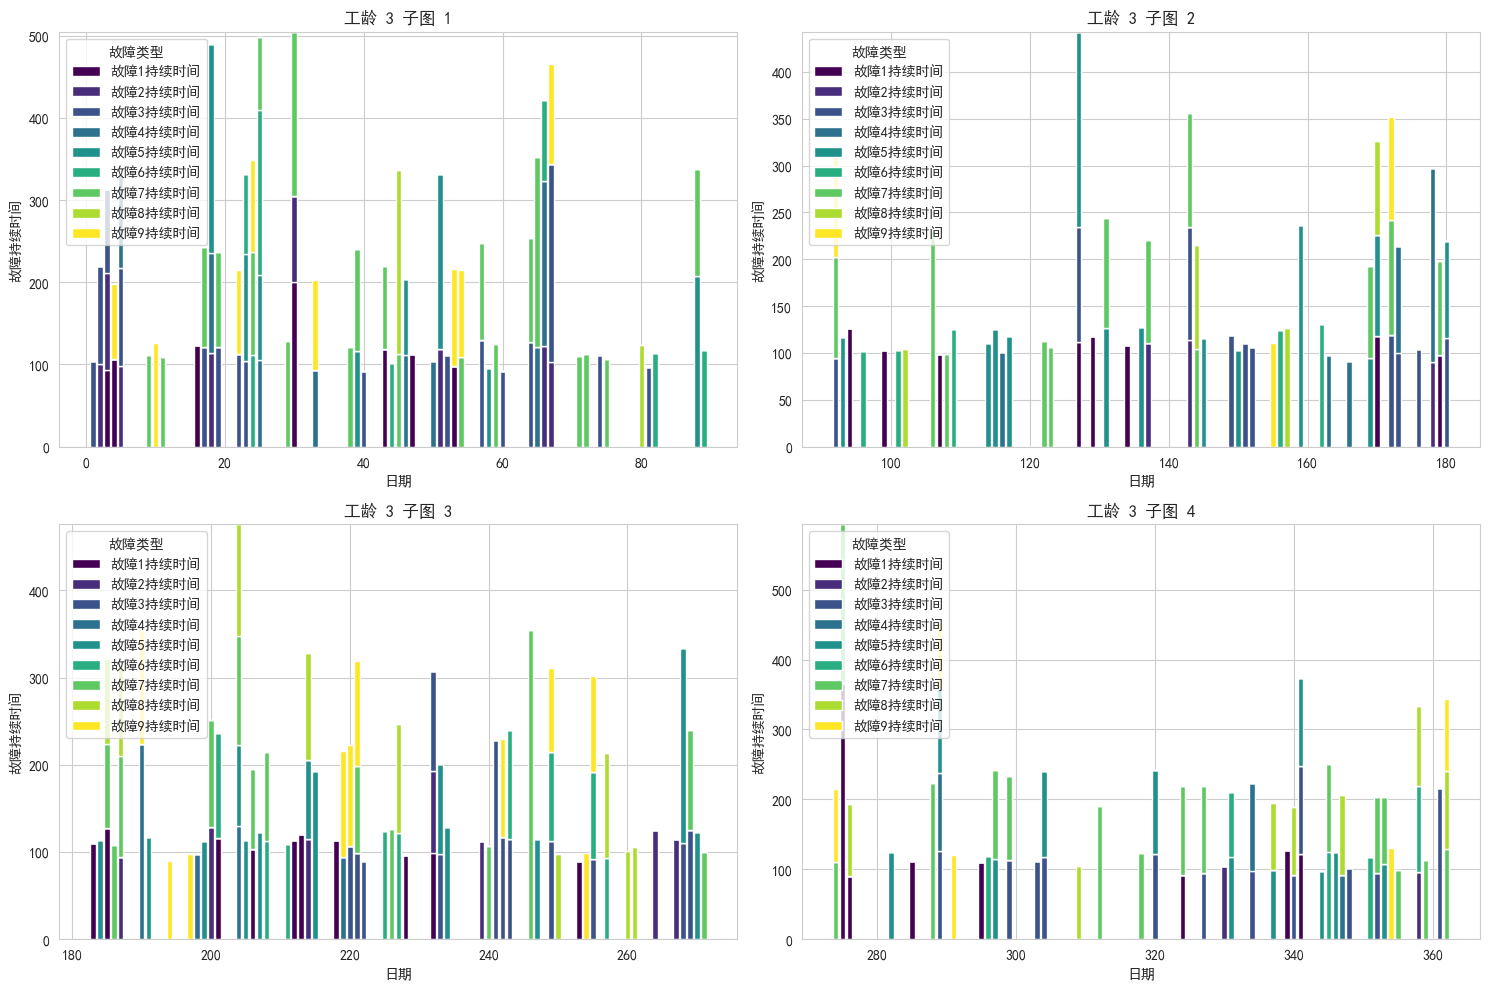

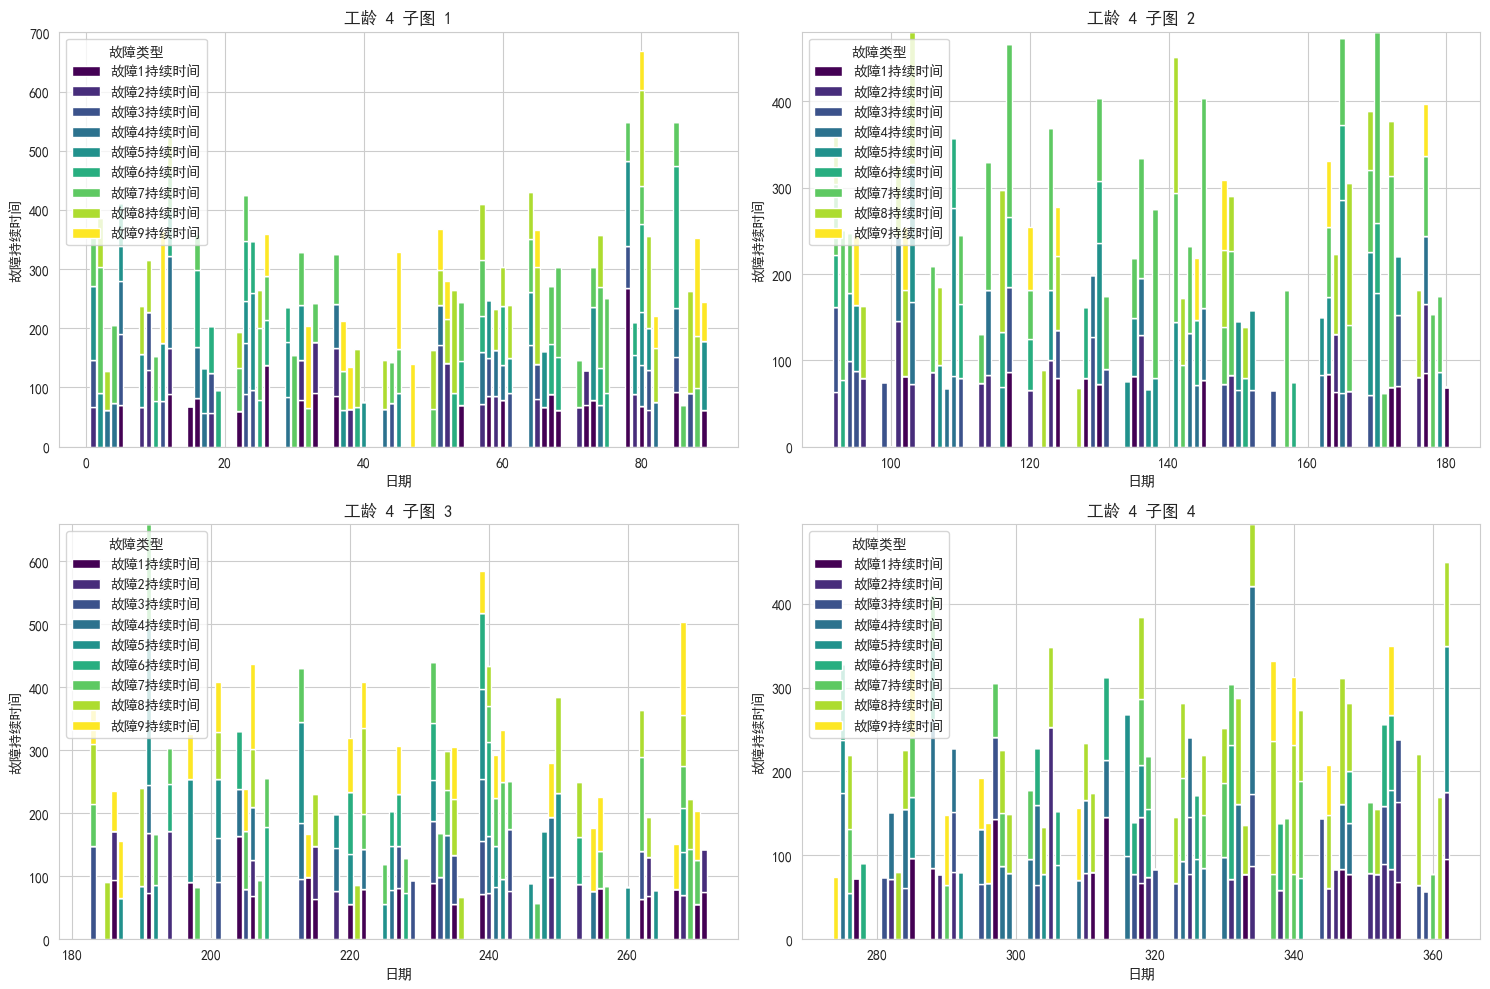

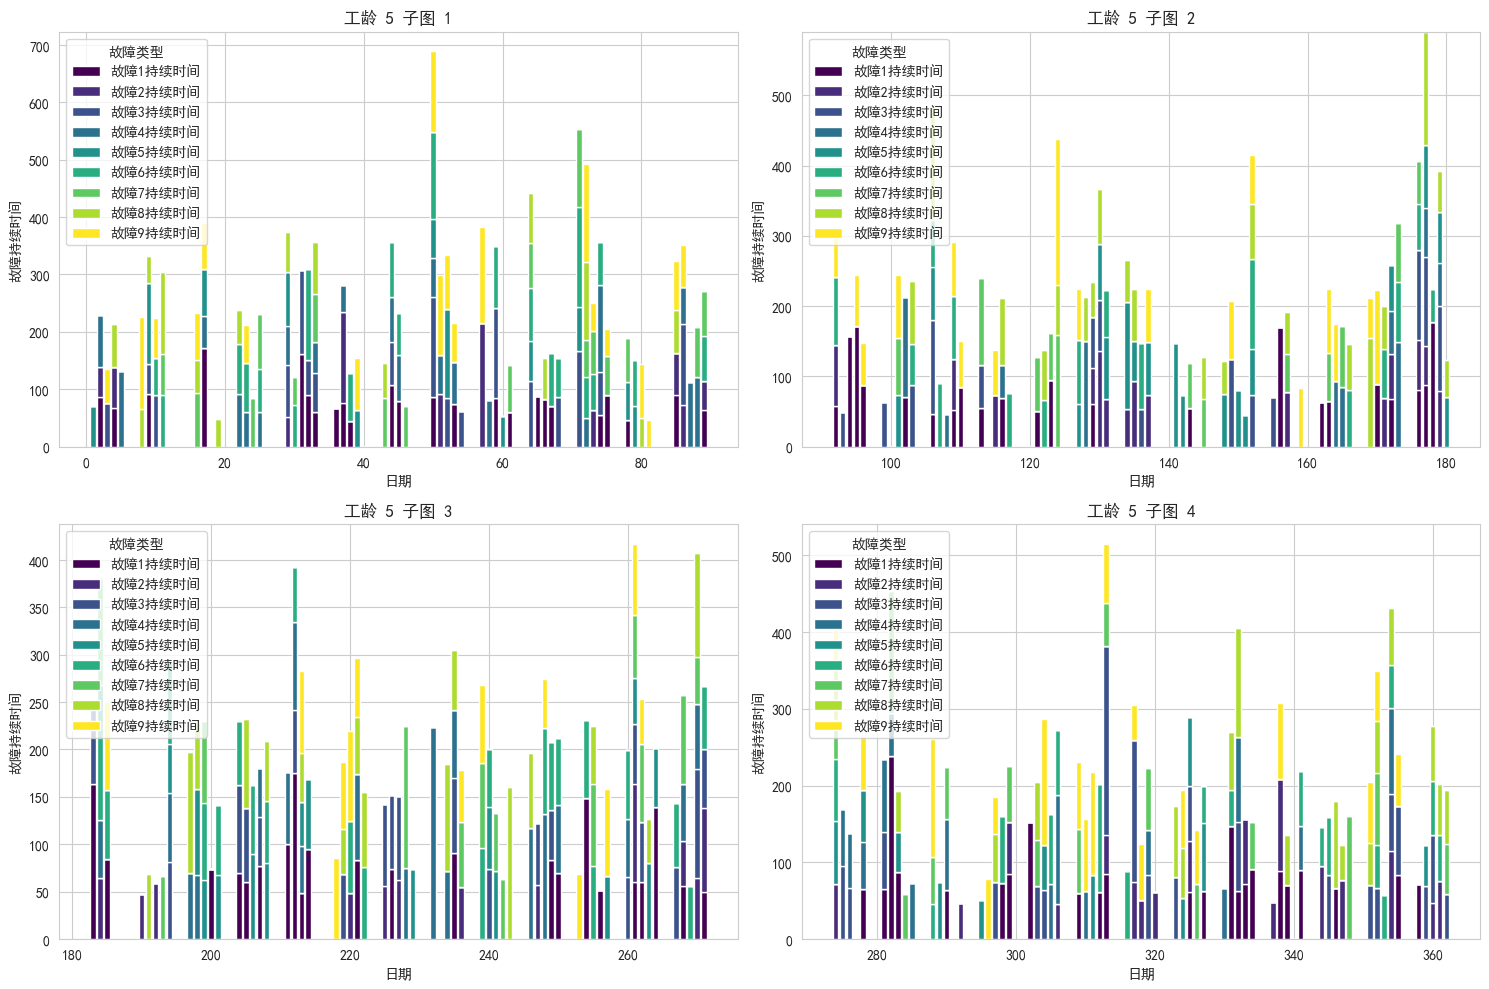

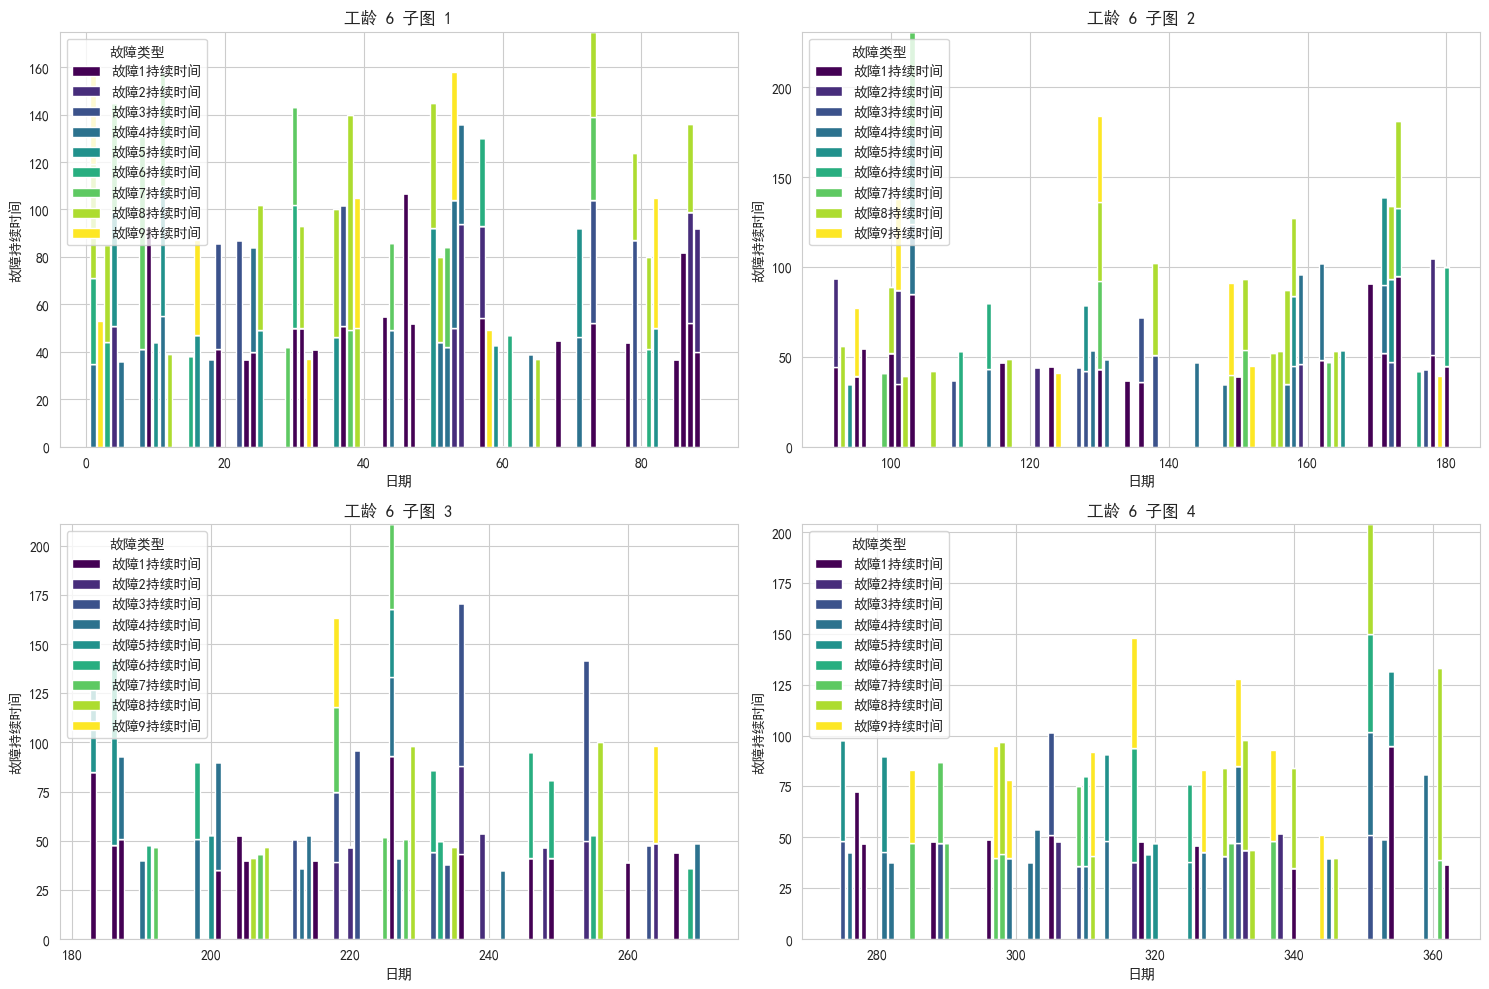

In [36]:
#绘制各个工龄各故障持续时间堆叠图 
df_grouped = df.groupby(['工龄', '日期'])[faults_duration].sum().reset_index()  

def plot_stacked_bar(data, ax, title):  
    # 仅选择故障持续时间的列，排除 '工龄' 和 '日期'
    faults_columns = data.columns.drop(['工龄', '日期'])
    bottom = np.zeros(len(data['日期']))  # 使用日期列的长度
    colors = plt.cm.viridis(np.linspace(0, 1, len(faults_columns)))  # 根据故障类型的数量生成颜色
    for i, column in enumerate(faults_columns):  # 遍历故障类型列
        ax.bar(data['日期'], data[column], label=column, bottom=bottom, color=colors[i])  
        bottom += data[column]  
    ax.set_title(title)  
    ax.set_xlabel('日期')  
    ax.set_ylabel('故障持续时间') 
    ax.legend(title='故障类型', loc='upper left')  # 移动图例位置

def plot_production_line(line_data, line_id):  
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10)) 
    axes = axes.flatten()  
  
    segment_size = len(line_data) // 4   
  
    for i in range(4):  
        start_idx = i * segment_size  
        end_idx = min((i + 1) * segment_size, len(line_data))  # 确保不会超出数据长度
        segment_data = line_data.iloc[start_idx:end_idx]
  
        plot_stacked_bar(segment_data, axes[i], f'工龄 {line_id} 子图 {i+1}')  
   
    plt.tight_layout()  
    plt.show()  

for line_id in df_grouped['工龄'].unique():  
    line_data = df_grouped[df_grouped['工龄'] == line_id]  
    plot_production_line(line_data, line_id)

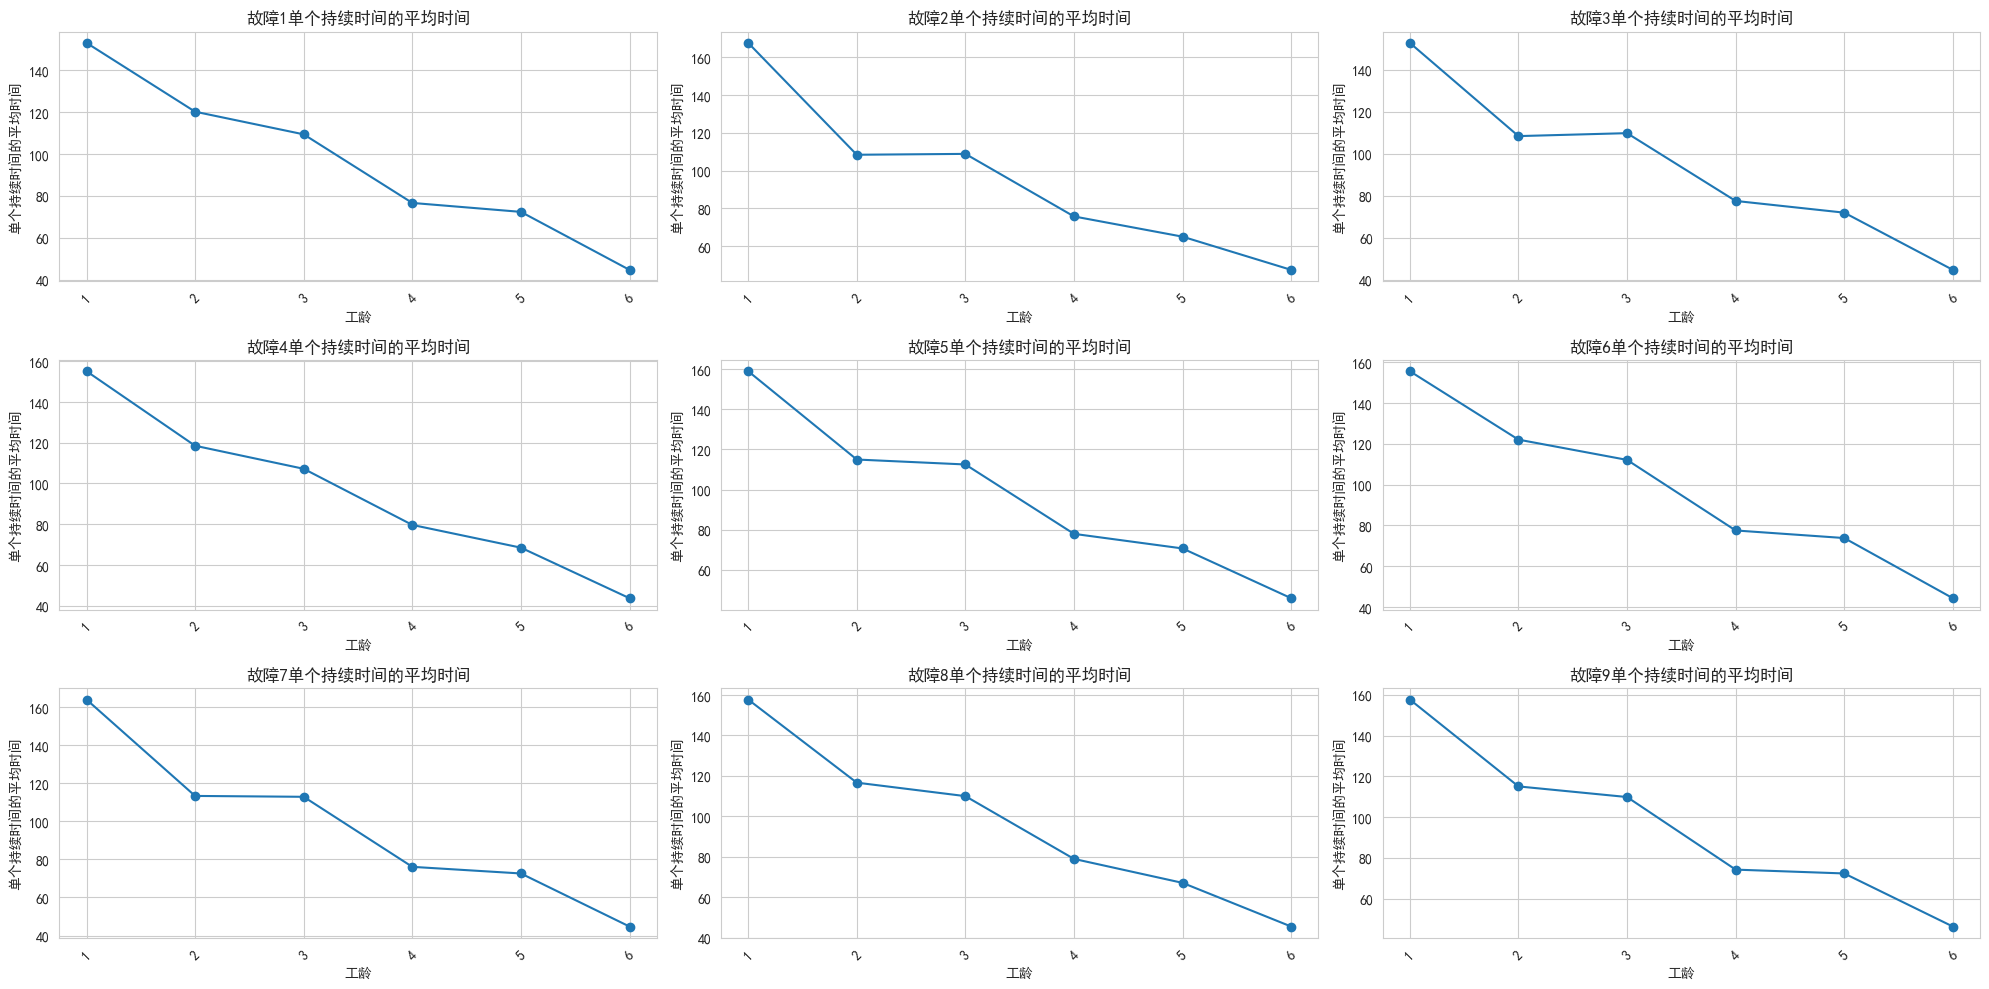

In [37]:
#绘制各工龄各个故障的持续时间图
for i in range(1, 10):  
    fault_duration_col = f'故障{i}持续时间'  
    fault_count_col = f'故障{i}'  
    df[f'故障{i}单个持续时间'] = df[fault_duration_col] / df[fault_count_col].replace(0, np.nan)  

avg_single_duration_per_seniority = df.groupby('工龄')[[f'故障{i}单个持续时间' for i in range(1, 10)]].mean()  
 
num_faults = 9    
num_seniority_levels = len(avg_single_duration_per_seniority.index.unique())  # 
num_cols = 3  
num_rows = (num_faults + num_cols - 1) // num_cols 
  
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))  
axs = axs.flatten()  #

for i, fault_label in enumerate(avg_single_duration_per_seniority.columns, 1):  
    ax = axs[i-1]  
    ax.plot(avg_single_duration_per_seniority.index, avg_single_duration_per_seniority[fault_label], marker='o')  
    ax.set_title(f'故障{i}单个持续时间的平均时间')  
    ax.set_xlabel('工龄')  
    ax.set_ylabel('单个持续时间的平均时间')  
    ax.set_xticks(avg_single_duration_per_seniority.index)  
    ax.set_xticklabels(avg_single_duration_per_seniority.index, rotation=45)  
  
plt.tight_layout()  
plt.show()

# 工龄与合格率的关系分析 

## 各工龄的平均合格率及合格率分布

各工龄平均合格率的最大差值为: 0.05%


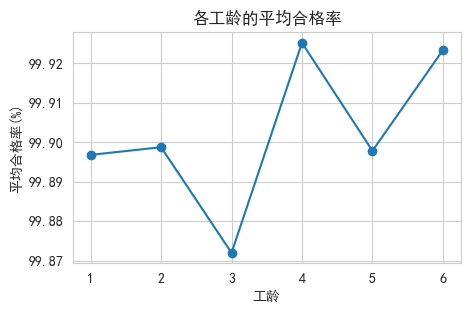

In [39]:
#绘制各工龄平均合格率
average_qualification_per_seniority = df.groupby('工龄')['合格率(%)'].mean()  

seniority_names_qualification = average_qualification_per_seniority.index.tolist()  
average_qualifications = average_qualification_per_seniority.values.tolist()  

plt.figure(figsize=(5, 3))  
plt.plot(seniority_names_qualification, average_qualifications, marker='o')  

plt.xlabel('工龄')  
plt.ylabel('平均合格率(%)')  
plt.title('各工龄的平均合格率')  

max_diff_qualification = average_qualification_per_seniority.max() - average_qualification_per_seniority.min()  
print(f"各工龄平均合格率的最大差值为: {max_diff_qualification:.2f}%")

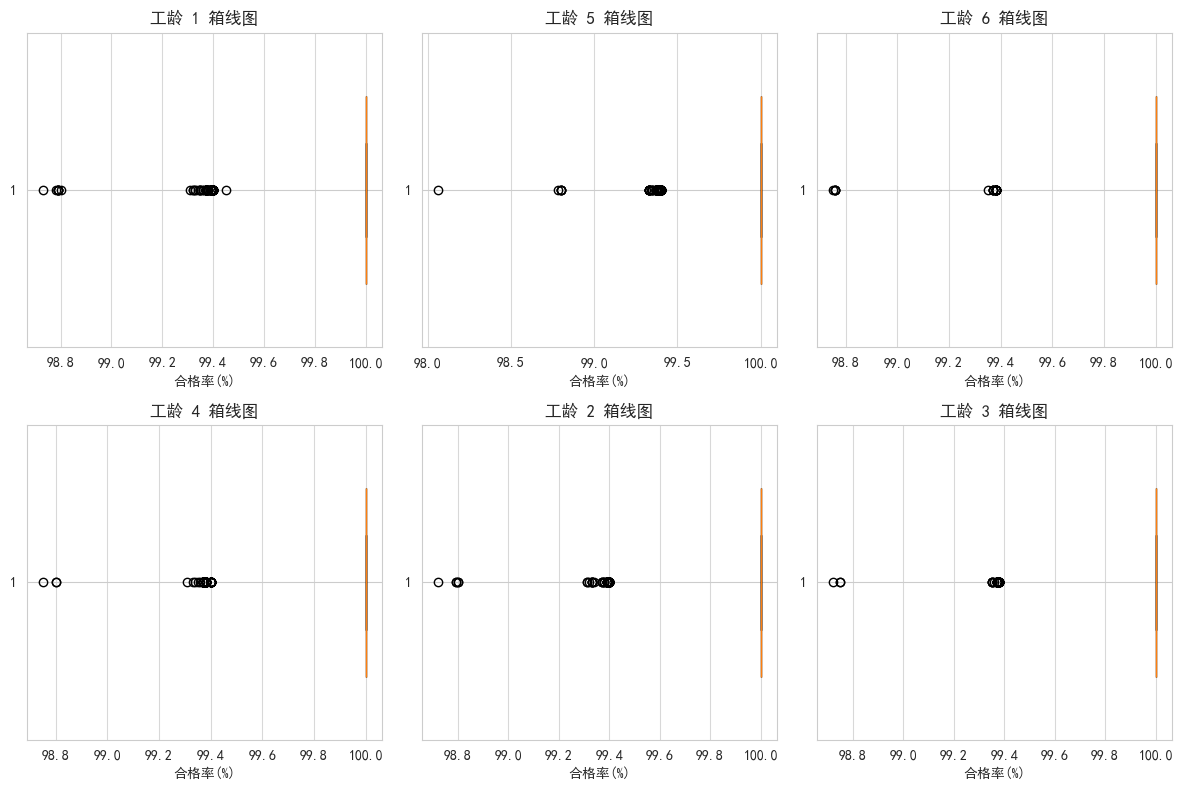

In [40]:
#绘制各工龄合格率箱线图
unique_work_ages = df['工龄'].unique() 
ncols = 3  
nrows = (len(unique_work_ages) + ncols - 1) // ncols  
  
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))  
  
for i, work_age in enumerate(unique_work_ages):  
    
    work_age_data = df[df['工龄'] == work_age]['合格率(%)']  

    boxplot_for_age(work_age_data, work_age, i + 1, xlabel = '合格率(%)')  
  
plt.tight_layout()  
plt.show()

## 合格率显著因素（故障3）与工龄的关系

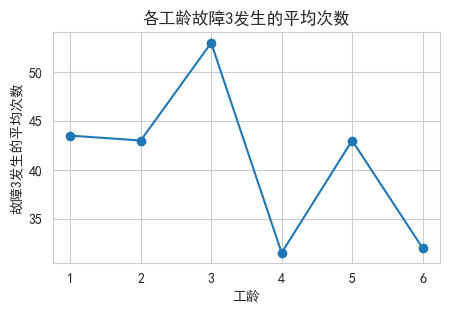

In [41]:
#绘制各工龄的故障3平均发生次数图
fault_3_total_per_seniority = df.groupby('工龄')['故障3'].sum()  

staff_counts_per_seniority = df.groupby('工龄')['操作人员编号'].nunique()  

valid_seniorities = staff_counts_per_seniority[staff_counts_per_seniority > 0].index  
 
average_fault_3_per_seniority = fault_3_total_per_seniority[valid_seniorities] / staff_counts_per_seniority[valid_seniorities]  

plt.figure(figsize=(5, 3))  
plt.plot(average_fault_3_per_seniority.index, average_fault_3_per_seniority.values, marker='o')  

plt.xlabel('工龄')  
plt.ylabel('故障3发生的平均次数')  
plt.title('各工龄故障3发生的平均次数')  
plt.show()

# 线性回归模型预测

In [42]:
df = pd.read_csv("combined_data.csv")

In [43]:
#线性回归预测产量
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

X_output = df.drop(['产量','日期','故障6','故障7','故障8','操作人员编号'], axis=1)
y_output = df['产量']

categorical_features = ['生产线编号', '工龄'] 
X_output = pd.get_dummies(X_output, columns=categorical_features)

X_output_train, X_output_test, y_output_train, y_output_test = train_test_split(X_output, y_output, test_size=0.2, random_state=42)

model_output = LinearRegression()

model_output.fit(X_output_train, y_output_train)

y_output_pred = model_output.predict(X_output_test)

mse_output = mean_squared_error(y_output_test, y_output_pred)
print(f"Mean Squared Error: {mse_output}")
print(f"Coefficients: {model_output.coef_}")

Mean Squared Error: 135.28429555923324
Coefficients: [ 1.09813400e+02 -6.05742727e+00 -3.49923896e+01  6.48976475e+01
  1.86287491e-02 -1.90219789e+00 -3.68553149e-01 -5.18878607e-02
 -6.86396204e-03 -6.70878424e-02 -5.93487403e-02 -4.65935779e-02
 -4.81399114e-02 -5.49342400e-02 -5.13700846e-02 -5.83560883e-02
 -2.70668440e+01  2.82833483e+01 -1.27908779e+01 -2.61270899e+01
  9.86356109e+00 -1.25803478e+01  2.75364781e+01  2.88114159e+01
  1.03683879e+01 -2.62980319e+01  1.74457192e+00  2.02319490e+01
 -1.25803478e+01  1.40938825e+00  1.98531644e+00 -1.27908779e+01]


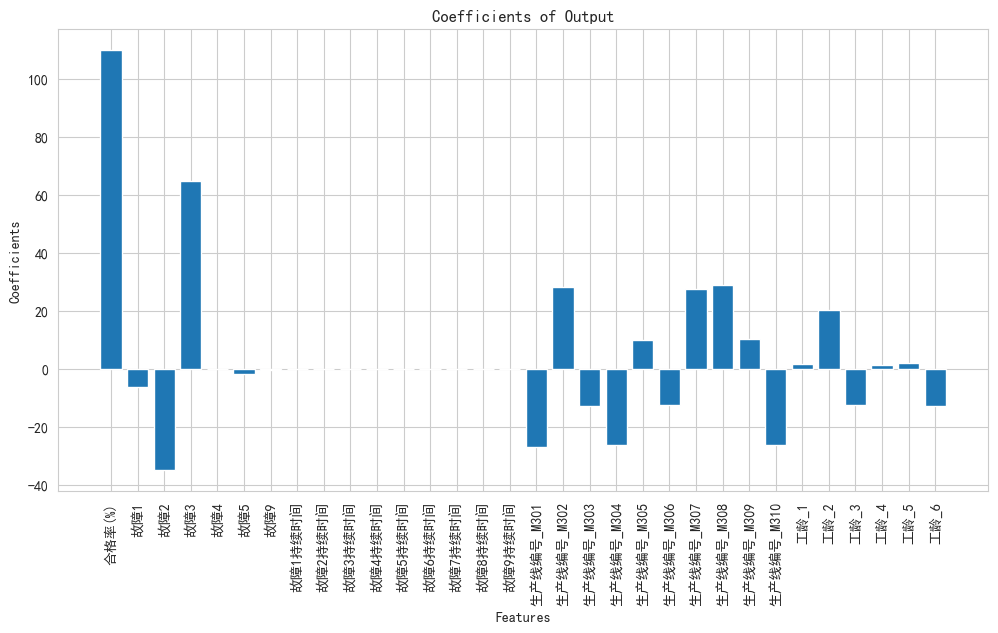

In [44]:
coefficients_output = model_output.coef_  
feature_names_output = X_output.columns  
  
plt.figure(figsize=(12, 6))  
plt.bar(feature_names_output, coefficients_output)  
  
plt.xlabel('Features')  
plt.ylabel('Coefficients')  
plt.title('Coefficients of Output')  
  
plt.xticks(rotation=90)  
plt.show()

In [45]:
lines = [f'生产线编号_M3{i:02d}' for i in range(1, 11)]  

predictions_output = []  

for seniority_col in ['工龄_{}'.format(i) for i in range(1, 7)]:   
    seniority_dict = {col: 0 for col in ['工龄_{}'.format(i) for i in range(1, 7)]}  
    seniority_dict[seniority_col] = 1  
      
    for line in lines:  
        new_data_output = {  
            **seniority_dict,            
            line: 1,                      
            **{col: X_output_train[col].mean() for col in X_output_train.columns if col not in ['工龄_1', '工龄_2', '工龄_3', '工龄_4', '工龄_5', '工龄_6', line]}  
        }  
          
        new_data_output_df = pd.DataFrame([new_data_output], columns=X_output_train.columns)  
          
        predicted_output = model_output.predict(new_data_output_df)  
      
        predictions_output.append((seniority_col, line, predicted_output[0]))  

predictions_output_df = pd.DataFrame(predictions_output, columns=['工龄类别', '生产线', '预测产量'])  
 
predictions_output_df['预测产量'] = predictions_output_df['预测产量'].round(2)  
print(predictions_output_df)

    工龄类别         生产线     预测产量
0   工龄_1  生产线编号_M301  1434.17
1   工龄_1  生产线编号_M302  1484.06
2   工龄_1  生产线编号_M303  1447.07
3   工龄_1  生产线编号_M304  1435.17
4   工龄_1  生产线编号_M305  1467.44
5   工龄_1  生产线编号_M306  1447.25
6   工龄_1  生产线编号_M307  1483.46
7   工龄_1  生产线编号_M308  1484.47
8   工龄_1  生产线编号_M309  1467.91
9   工龄_1  生产线编号_M310  1434.92
10  工龄_2  生产线编号_M301  1452.66
11  工龄_2  生产线编号_M302  1502.55
12  工龄_2  生产线编号_M303  1465.56
13  工龄_2  生产线编号_M304  1453.65
14  工龄_2  生产线编号_M305  1485.93
15  工龄_2  生产线编号_M306  1465.73
16  工龄_2  生产线编号_M307  1501.94
17  工龄_2  生产线编号_M308  1502.96
18  工龄_2  生产线编号_M309  1486.40
19  工龄_2  生产线编号_M310  1453.41
20  工龄_3  生产线编号_M301  1419.84
21  工龄_3  生产线编号_M302  1469.74
22  工龄_3  生产线编号_M303  1432.75
23  工龄_3  生产线编号_M304  1420.84
24  工龄_3  生产线编号_M305  1453.12
25  工龄_3  生产线编号_M306  1432.92
26  工龄_3  生产线编号_M307  1469.13
27  工龄_3  生产线编号_M308  1470.15
28  工龄_3  生产线编号_M309  1453.58
29  工龄_3  生产线编号_M310  1420.60
30  工龄_4  生产线编号_M301  1433.83
31  工龄_4  生产线编号_M302  1483.73
32  工龄_4  

In [46]:
pivot_table_output = predictions_output_df.pivot_table(index='工龄类别', columns='生产线', values='预测产量', aggfunc='first')  
print(pivot_table_output)
pivot_table_output.to_csv('pivot_table_output.csv', index=True)

生产线   生产线编号_M301  生产线编号_M302  生产线编号_M303  生产线编号_M304  生产线编号_M305  生产线编号_M306  \
工龄类别                                                                           
工龄_1     1434.17     1484.06     1447.07     1435.17     1467.44     1447.25   
工龄_2     1452.66     1502.55     1465.56     1453.65     1485.93     1465.73   
工龄_3     1419.84     1469.74     1432.75     1420.84     1453.12     1432.92   
工龄_4     1433.83     1483.73     1446.74     1434.83     1467.11     1446.91   
工龄_5     1434.41     1484.30     1447.32     1435.41     1467.69     1447.49   
工龄_6     1419.63     1469.53     1432.54     1420.63     1452.91     1432.71   

生产线   生产线编号_M307  生产线编号_M308  生产线编号_M309  生产线编号_M310  
工龄类别                                                  
工龄_1     1483.46     1484.47     1467.91     1434.92  
工龄_2     1501.94     1502.96     1486.40     1453.41  
工龄_3     1469.13     1470.15     1453.58     1420.60  
工龄_4     1483.12     1484.14     1467.57     1434.59  
工龄_5     1483.70     1484.71 

In [47]:
#线性回归预测合格率
X_rate = df[['故障3', '故障3持续时间','生产线编号','产量', '工龄']]
y_rate = df['合格率(%)']  
 
X_rate = pd.get_dummies(X_rate, columns=categorical_features)

X_rate_train, X_rate_test, y_rate_train, y_rate_test = train_test_split(X_rate, y_rate, test_size=0.2, random_state=42)

model_rate = LinearRegression()

model_rate.fit(X_rate_train, y_rate_train)

y_rate_pred = model_rate.predict(X_rate_test)

mse_rate = mean_squared_error(y_rate_test, y_rate_pred)
print(f"Mean Squared Error: {mse_rate}")

print(f"Coefficients: {model_rate.coef_}")

Mean Squared Error: 6.577912239863278e-05
Coefficients: [-6.17783719e-01 -7.19939140e-08  7.85023600e-05  1.06398111e-03
 -1.37183683e-03  6.75280931e-04  8.34294645e-04 -1.74739169e-04
 -1.39445059e-04 -8.01107545e-04 -6.49771235e-04 -5.95541921e-04
  1.15888508e-03  4.14209873e-04 -7.70281089e-04 -1.39445059e-04
  3.31871004e-05 -2.12951756e-04  6.75280931e-04]


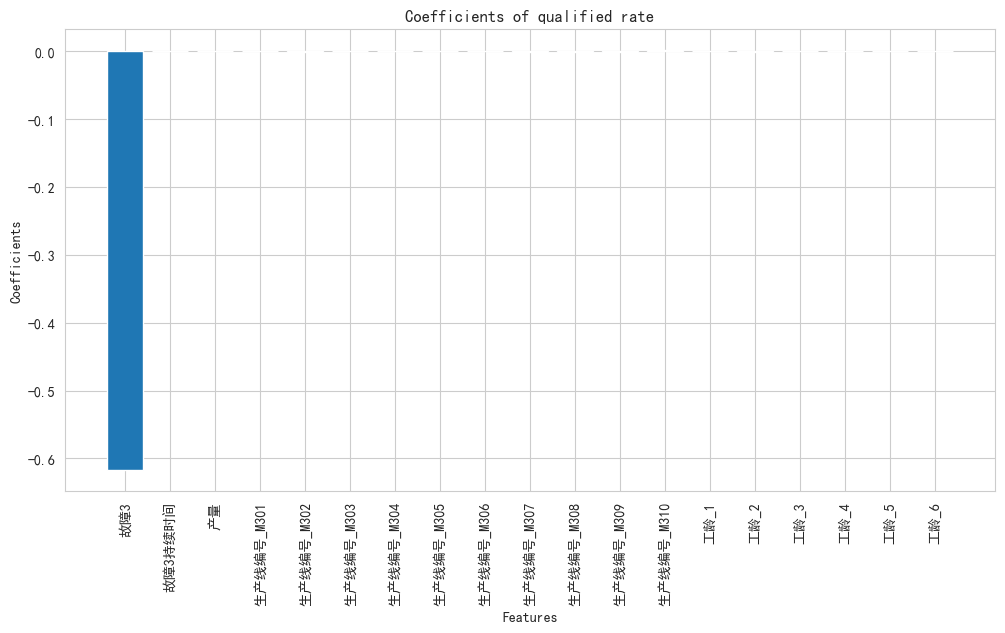

In [48]:
coefficients_rate = model_rate.coef_  
feature_names_rate = X_rate.columns  
  
plt.figure(figsize=(12, 6))  
plt.bar(feature_names_rate, coefficients_rate)  
  
plt.xlabel('Features')  
plt.ylabel('Coefficients')  
plt.title('Coefficients of qualified rate')  

plt.xticks(rotation=90)  
plt.show()

In [49]:
lines = [f'生产线编号_M3{i:02d}' for i in range(1, 11)]  

predictions_rate = []  

for seniority_col in ['工龄_{}'.format(i) for i in range(1, 7)]:   
    seniority_dict = {col: 0 for col in ['工龄_{}'.format(i) for i in range(1, 7)]}  
    seniority_dict[seniority_col] = 1  
      
    for line in lines:  
        new_data_rate = {  
            **seniority_dict,            
            line: 1,                      
            **{col: X_rate_train[col].mean() for col in X_rate_train.columns if col not in ['工龄_1', '工龄_2', '工龄_3', '工龄_4', '工龄_5', '工龄_6', line]}  
        }  
          
        new_data_rate_df = pd.DataFrame([new_data_rate], columns=X_rate_train.columns)  
          
        predicted_rate = model_rate.predict(new_data_rate_df)  
      
        predictions_rate.append((seniority_col, line, predicted_rate[0]))  

predictions_rate_df = pd.DataFrame(predictions_rate, columns=['工龄类别', '生产线', '预测合格率'])  
 
predictions_rate_df['预测合格率'] = predictions_rate_df['预测合格率'].round(4)  
print(predictions_rate_df)

    工龄类别         生产线    预测合格率
0   工龄_1  生产线编号_M301  99.9042
1   工龄_1  生产线编号_M302  99.9020
2   工龄_1  生产线编号_M303  99.9038
3   工龄_1  生产线编号_M304  99.9040
4   工龄_1  生产线编号_M305  99.9031
5   工龄_1  生产线编号_M306  99.9031
6   工龄_1  生产线编号_M307  99.9025
7   工龄_1  生产线编号_M308  99.9027
8   工龄_1  生产线编号_M309  99.9027
9   工龄_1  生产线编号_M310  99.9043
10  工龄_2  生产线编号_M301  99.9030
11  工龄_2  生产线编号_M302  99.9008
12  工龄_2  生产线编号_M303  99.9027
13  工龄_2  生产线编号_M304  99.9028
14  工龄_2  生产线编号_M305  99.9019
15  工龄_2  生产线编号_M306  99.9019
16  工龄_2  生产线编号_M307  99.9013
17  工龄_2  生产线编号_M308  99.9015
18  工龄_2  生产线编号_M309  99.9015
19  工龄_2  生产线编号_M310  99.9031
20  工龄_3  生产线编号_M301  99.9036
21  工龄_3  生产线编号_M302  99.9014
22  工龄_3  生产线编号_M303  99.9033
23  工龄_3  生产线编号_M304  99.9034
24  工龄_3  生产线编号_M305  99.9025
25  工龄_3  生产线编号_M306  99.9026
26  工龄_3  生产线编号_M307  99.9020
27  工龄_3  生产线编号_M308  99.9021
28  工龄_3  生产线编号_M309  99.9021
29  工龄_3  生产线编号_M310  99.9037
30  工龄_4  生产线编号_M301  99.9038
31  工龄_4  生产线编号_M302  99.9016
32  工龄_4  

In [50]:
pivot_table_rate = predictions_rate_df.pivot_table(index='工龄类别', columns='生产线', values='预测合格率', aggfunc='first')  
print(pivot_table_rate)
pivot_table_rate.to_csv('pivot_table_rate.csv', index=True)

生产线   生产线编号_M301  生产线编号_M302  生产线编号_M303  生产线编号_M304  生产线编号_M305  生产线编号_M306  \
工龄类别                                                                           
工龄_1     99.9042     99.9020     99.9038     99.9040     99.9031     99.9031   
工龄_2     99.9030     99.9008     99.9027     99.9028     99.9019     99.9019   
工龄_3     99.9036     99.9014     99.9033     99.9034     99.9025     99.9026   
工龄_4     99.9038     99.9016     99.9035     99.9036     99.9027     99.9027   
工龄_5     99.9036     99.9014     99.9032     99.9034     99.9025     99.9025   
工龄_6     99.9045     99.9023     99.9041     99.9042     99.9033     99.9034   

生产线   生产线编号_M307  生产线编号_M308  生产线编号_M309  生产线编号_M310  
工龄类别                                                  
工龄_1     99.9025     99.9027     99.9027     99.9043  
工龄_2     99.9013     99.9015     99.9015     99.9031  
工龄_3     99.9020     99.9021     99.9021     99.9037  
工龄_4     99.9021     99.9023     99.9023     99.9039  
工龄_5     99.9019     99.9020 